In [1]:
import numpy as np
import os
import pandas as pd
import math

from ctapipe.utils import get_dataset_path
from ctapipe.io import EventSource, EventSeeker
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from matplotlib import pyplot as plt
from astropy import units as u

from eventio.simtel.simtelfile import SimTelFile
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy.interpolate import interp1d

In [3]:
def read_simple_data(filename, n_skip):
   
    wavelength = []
    transmissivity = []

    with open(filename, "r") as file:
        lines = file.readlines()[n_skip:]
        for line in lines:
            words = line.split()
            #print(words[0], words[1])
            #print(words[0], ' ; ', words[1])    
            wavelength.append(float(words[0]))
            transmissivity.append(float(words[1]))
                
    return wavelength, transmissivity

In [4]:
gamma_req, cr_req = read_simple_data('/home/andrii/work/sim_telarray/analysis/spectrums/IntensityRes.txt', 0)
gamma_req_nsb, cr_req_nsb = read_simple_data('/home/andrii/work/sim_telarray/analysis/spectrums/IntensityResHighNSB.txt', 0)

In [5]:
def read_data(filename):
   
    pixel = []
    n_pe = []
    n_pe_err = []
    q_res = []
    q_res_err = []

    with open(filename, "r") as file:
        lines = file.readlines()[1:]
        for line in lines:
            words = line.split()
        
            if len(words) == 4:
                pixel.append(float(words[0]))
                n_pe.append(float(words[1]))
                q_res.append(float(words[2]))
                q_res_err.append(float(words[3]))
                
            elif len(words) == 5:
                pixel.append(float(words[0]))
                n_pe.append(float(words[1]))
                n_pe_err.append(float(words[2]))
                q_res.append(float(words[3]))
                q_res_err.append(float(words[4]))
                
    return pixel, n_pe, n_pe_err, q_res, q_res_err

In [6]:
def find_files(path, cut):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    files = []
    for i_file in onlyfiles:
        if i_file[0] != '.':
            if (cut in i_file) or ("2k" in i_file) or ("1k" in i_file):
                files.append(i_file)
            
    return files

In [7]:
def my_sort(a, b, a_err, b_err):
    
    for i in range (len(a)):
        for j in range (i+1, len(a), 1):
            if(a[i]>a[j]):
                a[i], a[j] = swap_elements(a[i], a[j])
                b[i], b[j] = swap_elements(b[i], b[j])
                a_err[i], a_err[j] = swap_elements(a_err[i], a_err[j])
                b_err[i], b_err[j] = swap_elements(b_err[i], b_err[j])

In [8]:
def my_sort_3el(a, b, a_err):
    
    for i in range (len(a)):
        for j in range (i+1, len(a), 1):
            if(a[i]>a[j]):
                a[i], a[j] = swap_elements(a[i], a[j])
                b[i], b[j] = swap_elements(b[i], b[j])
                a_err[i], a_err[j] = swap_elements(a_err[i], a_err[j])

In [9]:
def swap_elements(a, b):
    tmp = a
    a = b
    b = tmp
    return a, b

In [10]:
def read_files_data(path, cut, PDE):
    
    pixel = []
    npe = []
    cr = []
    cr_err = []
    
    n_pe_mean = []
    n_gamma_mean = []
    n_pe_std = []
    
    cr_mean = []
    cr_mean_err = []
    
    files = find_files(path, cut)
    
    for item, i_file in enumerate(files):
        #print(item)
        pixel_tmp = []
        n_pe_tmp = []
        n_pe_err_tmp = []
        cr_tmp = []
        cr_err_tmp = []
    
        pixel_tmp, n_pe_tmp, n_pe_err_tmp, cr_tmp, cr_err_tmp = read_data(path + i_file)
    
        pixel.append(pixel_tmp)
    
        npe.append(n_pe_tmp)
        cr.append(cr_tmp)
        cr_err.append(cr_err_tmp)
    
        n_pe_mean.append(np.mean(n_pe_tmp))
        n_pe_std.append(np.std(n_pe_tmp))
        n_gamma_mean.append(np.mean(n_pe_tmp)/PDE)
        cr_mean.append(np.mean(cr_tmp))
        cr_mean_err.append(np.mean(cr_err_tmp))
        
    #npe_fl = np.array(npe).flatten('C')
    #ngamma_fl = np.array(npe).flatten('C')/PDE
    #q_fl = np.array(cr).flatten('C')
    #q_err_fl = np.array(cr_err).flatten('C')

    my_sort(n_gamma_mean, cr_mean, cr_mean_err, n_pe_std)
    my_sort_3el(npe, cr, cr_err)
    
    return n_gamma_mean, n_pe_std, cr_mean, cr_mean_err, npe, cr, cr_err

In [11]:
charge_resolution_poisson_gammas = []
gammas_poisson = np.arange(0.1, 1200, 0.3)

for i in range(len(gammas_poisson)):
    charge_resolution_poisson_gammas.append(1./math.sqrt(gammas_poisson[i]))

In [13]:
reflectivity = 0.92284
funnel = 0.885447
ff = 0.91939

In [14]:
pde_pmt_pmma = 0.19386629996529098*reflectivity*funnel*ff
n_gamma_pmt_pmma_mean, n_pe_pmt_pmma_std, cr_pmt_pmma_mean, cr_pmt_pmma_mean_err, npe_pmt_pmma, cr_pmt_pmma, cr_pmt_pmma_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/PMT/PMMA/nsb_0.24586/Chrenkov/PDE_43/asum_286/both_gains/", "4k", pde_pmt_pmma)

npe_pmt_pmma_mean = np.array(n_gamma_pmt_pmma_mean)*pde_pmt_pmma
npe_pmt_pmma_fl = np.array(npe_pmt_pmma).flatten('C')
ngamma_pmt_pmma_fl = np.array(npe_pmt_pmma).flatten('C')/pde_pmt_pmma
q_pmt_pmma_fl = np.array(cr_pmt_pmma).flatten('C')
q_pmt_pmma_err_fl = np.array(cr_pmt_pmma_err).flatten('C')

In [15]:
n_gamma_pmt_lg_pmma_mean, n_pe_pmt_lg_pmma_std, cr_pmt_lg_pmma_mean, cr_pmt_lg_pmma_mean_err, npe_pmt_lg_pmma, cr_pmt_lg_pmma, cr_pmt_lg_pmma_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/PMT/PMMA/nsb_0.24586/Chrenkov/PDE_43/asum_286/low_gain/", "4k", pde_pmt_pmma)

npe_pmt_lg_pmma_mean = np.array(n_gamma_pmt_lg_pmma_mean)*pde_pmt_pmma
npe_pmt_lg_pmma_fl = np.array(npe_pmt_lg_pmma).flatten('C')
ngamma_pmt_lg_pmma_fl = np.array(npe_pmt_lg_pmma).flatten('C')/pde_pmt_pmma
q_pmt_lg_pmma_fl = np.array(cr_pmt_lg_pmma).flatten('C')
q_pmt_lg_pmma_err_fl = np.array(cr_pmt_lg_pmma_err).flatten('C')

In [16]:
pde_pmt_pmma

0.14564349050475525

In [17]:
pde_hkb_pmma_5 = 0.2246145450233386*reflectivity*funnel*ff
n_gamma_hkb_pmma_5_mean, n_pe_hkb_pmma_5_std, cr_hkb_pmma_5_mean, cr_hkb_pmma_5_mean_err, npe_hkb_pmma_5, cr_hkb_pmma_5, cr_hkb_pmma_5_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/PMT/PMMA/nsb_0.24586/Chrenkov/PDE_43/Integral_8ns/", "4k", pde_hkb_pmma_5)

npe_hkb_pmma_5_mean = np.array(n_gamma_hkb_pmma_5_mean)*pde_hkb_pmma_5
npe_hkb_pmma_5_fl = np.array(npe_hkb_pmma_5).flatten('C')
ngamma_hkb_pmma_5_fl = np.array(npe_hkb_pmma_5).flatten('C')/pde_hkb_pmma_5
q_hkb_pmma_5_fl = np.array(cr_hkb_pmma_5).flatten('C')
q_hkb_pmma_5_err_fl = np.array(cr_hkb_pmma_5_err).flatten('C')

In [18]:
pde_hkb_borofloat_8 = 0.18843703333692147*reflectivity*funnel*ff
n_gamma_hkb_8_mean, n_pe_hkb_8_std, cr_hkb_8_mean, cr_hkb_8_mean_err, npe_hkb_8, cr_hkb_8, cr_hkb_8_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.08/LCT5/Borofloat/nsb_0.1076/Cherenkov/PDE_47/", "4k", pde_hkb_borofloat_8)

npe_hkb_8_mean = pde_hkb_borofloat_8*np.array(pde_hkb_borofloat_8)
npe_hkb_8_fl = np.array(npe_hkb_8).flatten('C')
ngamma_hkb_8_fl = np.array(npe_hkb_8).flatten('C')/pde_hkb_borofloat_8
q_hkb_8_fl = np.array(cr_hkb_8).flatten('C')
q_hkb_8_err_fl = np.array(cr_hkb_8_err).flatten('C')

pde_hkb_pmma_8 = 0.28770543712525437*reflectivity*funnel*ff
n_gamma_hkb_pmma_8_mean, n_pe_hkb_pmma_8_std, cr_hkb_pmma_8_mean, cr_hkb_pmma_8_mean_err, npe_hkb_pmma_8, cr_hkb_pmma_8, cr_hkb_pmma_8_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.08/LCT5/PMMA/nsb_0.386/Cherenkov/PDE_47/", "4k", pde_hkb_pmma_8)

npe_hkb_pmma_8_mean = pde_hkb_pmma_8*np.array(n_gamma_hkb_pmma_8_mean)
npe_hkb_pmma_8_fl = np.array(npe_hkb_pmma_8).flatten('C')
ngamma_hkb_pmma_8_fl = np.array(npe_hkb_pmma_8).flatten('C')/pde_hkb_pmma_8
q_hkb_pmma_8_fl = np.array(cr_hkb_pmma_8).flatten('C')
q_hkb_pmma_8_err_fl = np.array(cr_hkb_pmma_8_err).flatten('C')

In [19]:
pde_hkb_borofloat_15 = 0.2142800614188838*reflectivity*funnel*ff
n_gamma_hkb_15_mean, n_pe_hkb_15_std, cr_hkb_15_mean, cr_hkb_15_mean_err, npe_hkb_15, cr_hkb_15, cr_hkb_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5/Borofloat/nsb_0.109/PDE_53/", "4k", pde_hkb_borofloat_15)

npe_hkb_15_mean = pde_hkb_borofloat_15*np.array(n_gamma_hkb_15_mean)
npe_hkb_15_fl = np.array(npe_hkb_15).flatten('C')
ngamma_hkb_15_fl = np.array(npe_hkb_15).flatten('C')/pde_hkb_borofloat_15
q_hkb_15_fl = np.array(cr_hkb_15).flatten('C')
q_hkb_15_err_fl = np.array(cr_hkb_15_err).flatten('C')

pde_hkb_pmma_15 = 0.33259653404926626*reflectivity*funnel*ff
n_gamma_hkb_pmma_15_mean, n_pe_hkb_pmma_15_std, cr_hkb_pmma_15_mean, cr_hkb_pmma_15_mean_err, npe_hkb_pmma_15, cr_hkb_pmma_15, cr_hkb_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5/PMMA/nsb_0.424/PDE_53/", "4k", pde_hkb_pmma_15)

npe_hkb_pmma_15_mean = pde_hkb_pmma_15*np.array(n_gamma_hkb_pmma_15_mean)
npe_hkb_pmma_15_fl = np.array(npe_hkb_pmma_15).flatten('C')
ngamma_hkb_pmma_15_fl = np.array(npe_hkb_pmma_15).flatten('C')/pde_hkb_pmma_15
q_hkb_pmma_15_fl = np.array(cr_hkb_pmma_15).flatten('C')
q_hkb_pmma_15_err_fl = np.array(cr_hkb_pmma_15_err).flatten('C')

ngamma_hkb_pmma_15_mean = np.mean(np.array(npe_hkb_pmma_15)/pde_hkb_pmma_15, axis = 1)
ngamma_hkb_pmma_15_std = np.std(np.array(npe_hkb_pmma_15)/pde_hkb_pmma_15, axis = 1)
cr_hkb_pmma_15_mean = np.mean(cr_hkb_pmma_15, axis=1)
cr_hkb_pmma_15_std = np.std(cr_hkb_pmma_15, axis=1)

In [20]:
pde_hkb_borofloat_25 = 0.22007393815410642*reflectivity*funnel*ff
n_gamma_hkb_25_mean, n_pe_hkb_25_std, cr_hkb_25_mean, cr_hkb_25_mean_err, npe_hkb_25, cr_hkb_25, cr_hkb_25_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.25/LCT5/Borofloat/nsb_0.1103/Cherenkov/PDE_54/", "4k", pde_hkb_borofloat_25)

npe_hkb_25_mean = pde_hkb_borofloat_25*np.array(n_gamma_hkb_25_mean)
npe_hkb_25_fl = np.array(npe_hkb_25).flatten('C')
ngamma_hkb_25_fl = np.array(npe_hkb_25).flatten('C')/pde_hkb_borofloat_25
q_hkb_25_fl = np.array(cr_hkb_25).flatten('C')
q_hkb_25_err_fl = np.array(cr_hkb_25_err).flatten('C')

pde_hkb_pmma_25 = 0.3431109359598701*reflectivity*funnel*ff
n_gamma_hkb_pmma_25_mean, n_pe_hkb_pmma_25_std, cr_hkb_pmma_25_mean, cr_hkb_pmma_25_mean_err, npe_hkb_pmma_25, cr_hkb_pmma_25, cr_hkb_pmma_25_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.25/LCT5/PMMA/nsb_0.43774/Cherenkov/PDE_54/", "4k", pde_hkb_pmma_25)

npe_hkb_pmma_25_mean = pde_hkb_pmma_25*np.array(n_gamma_hkb_pmma_25_mean)
npe_hkb_pmma_25_fl = np.array(npe_hkb_pmma_25).flatten('C')
ngamma_hkb_pmma_25_fl = np.array(npe_hkb_pmma_25).flatten('C')/pde_hkb_pmma_25
q_hkb_pmma_25_fl = np.array(cr_hkb_pmma_25).flatten('C')
q_hkb_pmma_25_err_fl = np.array(cr_hkb_pmma_25_err).flatten('C')

In [21]:
pde_fbk_borofloat_8 = 0.1467944281612396*reflectivity*funnel*ff
n_gamma_fbk_8_mean, n_pe_fbk_8_std, cr_fbk_8_mean, cr_fbk_8_mean_err, npe_fbk_8, cr_fbk_8, cr_fbk_8_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.08/NUV-HD/Borofloat/nsb_0.06506/Cherenkov/PDE_40/", "4k", pde_fbk_borofloat_8)

npe_fbk_8_fl = np.array(npe_fbk_8).flatten('C')
ngamma_fbk_8_fl = np.array(npe_fbk_8).flatten('C')/pde_fbk_borofloat_8
q_fbk_8_fl = np.array(cr_fbk_8).flatten('C')
q_fbk_8_err_fl = np.array(cr_fbk_8_err).flatten('C')

pde_fbk_pmma_8 = 0.19599621749684507*reflectivity*funnel*ff
n_gamma_fbk_pmma_8_mean, n_pe_fbk_pmma_8_std, cr_fbk_pmma_8_mean, cr_fbk_pmma_8_mean_err, npe_fbk_pmma_8, cr_fbk_pmma_8, cr_fbk_pmma_8_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.08/NUV-HD/PMMA/nsb_0.16039/Cherenkov/PDE_40/", "4k", pde_fbk_pmma_8)

npe_fbk_pmma_8_fl = np.array(npe_fbk_pmma_8).flatten('C')
ngamma_fbk_pmma_8_fl = np.array(npe_fbk_pmma_8).flatten('C')/pde_fbk_pmma_8
q_fbk_pmma_8_fl = np.array(cr_fbk_pmma_8).flatten('C')
q_fbk_pmma_8_err_fl = np.array(cr_fbk_pmma_8_err).flatten('C')

In [22]:
pde_fbk_borofloat_15 = 0.18516416150784262*reflectivity*funnel*ff
n_gamma_fbk_15_mean, n_pe_fbk_15_std, cr_fbk_15_mean, cr_fbk_15_mean_err, npe_fbk_15, cr_fbk_15, cr_fbk_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/NUV-HD/Borofloat/nsb_0.0838/PDE_49/", "4k", pde_fbk_borofloat_15)

npe_fbk_15_fl = np.array(npe_fbk_15).flatten('C')
ngamma_fbk_15_fl = np.array(npe_fbk_15).flatten('C')/pde_fbk_borofloat_15
q_fbk_15_fl = np.array(cr_fbk_15).flatten('C')
q_fbk_15_err_fl = np.array(cr_fbk_15_err).flatten('C')

pde_fbk_pmma_15 = 0.2528776154621672*reflectivity*funnel*ff
n_gamma_fbk_pmma_15_mean, n_pe_fbk_pmma_15_std, cr_fbk_pmma_15_mean, cr_fbk_pmma_15_mean_err, npe_fbk_pmma_15, cr_fbk_pmma_15, cr_fbk_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/NUV-HD/PMMA/nsb_0.224/PDE_49/", "4k", pde_fbk_pmma_15)

npe_fbk_pmma_15_fl = np.array(npe_fbk_pmma_15).flatten('C')
ngamma_fbk_pmma_15_fl = np.array(npe_fbk_pmma_15).flatten('C')/pde_fbk_pmma_15
q_fbk_pmma_15_fl = np.array(cr_fbk_pmma_15).flatten('C')
q_fbk_pmma_15_err_fl = np.array(cr_fbk_pmma_15_err).flatten('C')

In [23]:
pde_fbk_borofloat_25 = 0.20574651840867458*reflectivity*funnel*ff
n_gamma_fbk_25_mean, n_pe_fbk_25_std, cr_fbk_25_mean, cr_fbk_25_mean_err, npe_fbk_25, cr_fbk_25, cr_fbk_25_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.25/NUV-HD/Borofloat/nsb_0.09471/Cherenkov/PDE_52/", "4k", pde_fbk_borofloat_25)

npe_fbk_25_fl = np.array(npe_fbk_25).flatten('C')
ngamma_fbk_25_fl = np.array(npe_fbk_25).flatten('C')/pde_fbk_borofloat_25
q_fbk_25_fl = np.array(cr_fbk_25).flatten('C')
q_fbk_25_err_fl = np.array(cr_fbk_25_err).flatten('C')

pde_fbk_pmma_25 = 0.2881642484338802*reflectivity*funnel*ff
n_gamma_fbk_pmma_25_mean, n_pe_fbk_pmma_25_std, cr_fbk_pmma_25_mean, cr_fbk_pmma_25_mean_err, npe_fbk_pmma_25, cr_fbk_pmma_25, cr_fbk_pmma_25_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.25/NUV-HD/PMMA/nsb_0.27137/Cherenkov/PDE_52/", "4k", pde_fbk_pmma_25)

npe_fbk_pmma_25_fl = np.array(npe_fbk_pmma_25).flatten('C')
ngamma_fbk_pmma_25_fl = np.array(npe_fbk_pmma_25).flatten('C')/pde_fbk_pmma_25
q_fbk_pmma_25_fl = np.array(cr_fbk_pmma_25).flatten('C')
q_fbk_pmma_25_err_fl = np.array(cr_fbk_pmma_25_err).flatten('C')

In [24]:
pde_hkb_nuv_borofloat_15 = 0.2697*reflectivity*funnel*ff
n_gamma_hkb_nuv_15_mean, n_pe_hkb_nuv_15_std, cr_hkb_nuv_15_mean, cr_hkb_nuv_15_mean_err, npe_hkb_nuv_15, cr_hkb_nuv_15, cr_hkb_nuv_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV/Borofloat/nsb_0.126/PDE_60/", "4k", pde_hkb_nuv_borofloat_15)

npe_hkb_nuv_15_mean = pde_hkb_nuv_borofloat_15*np.array(n_gamma_hkb_nuv_15_mean)
npe_hkb_nuv_15_fl = np.array(npe_hkb_nuv_15).flatten('C')
ngamma_hkb_nuv_15_fl = np.array(npe_hkb_nuv_15).flatten('C')/pde_hkb_nuv_borofloat_15
q_hkb_nuv_15_fl = np.array(cr_hkb_nuv_15).flatten('C')
q_hkb_nuv_15_err_fl = np.array(cr_hkb_nuv_15_err).flatten('C')
ngamma_hkb_nuv_15_mean = np.mean(np.array(npe_hkb_nuv_15)/pde_hkb_nuv_borofloat_15, axis = 1)
ngamma_hkb_nuv_15_std = np.std(np.array(npe_hkb_nuv_15)/pde_hkb_nuv_borofloat_15, axis = 1)
cr_hkb_nuv_15_mean = np.mean(cr_hkb_nuv_15, axis=1)
cr_hkb_nuv_15_std = np.std(cr_hkb_nuv_15, axis=1)


pde_hkb_nuv_2x_borofloat_15 = 0.2697*reflectivity*funnel*ff
n_gamma_hkb_nuv_2x_15_mean, n_pe_hkb_nuv_2x_15_std, cr_hkb_nuv_2x_15_mean, cr_hkb_nuv_2x_15_mean_err, npe_hkb_nuv_2x_15, cr_hkb_nuv_2x_15, cr_hkb_nuv_2x_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV/Borofloat/nsb_2x0.126/PDE_60/", "4k", pde_hkb_nuv_2x_borofloat_15)

npe_hkb_nuv_2x_15_mean = pde_hkb_nuv_2x_borofloat_15*np.array(n_gamma_hkb_nuv_2x_15_mean)
npe_hkb_nuv_2x_15_fl = np.array(npe_hkb_nuv_2x_15).flatten('C')
ngamma_hkb_nuv_2x_15_fl = np.array(npe_hkb_nuv_2x_15).flatten('C')/pde_hkb_nuv_2x_borofloat_15
q_hkb_nuv_2x_15_fl = np.array(cr_hkb_nuv_2x_15).flatten('C')
q_hkb_nuv_2x_15_err_fl = np.array(cr_hkb_nuv_2x_15_err).flatten('C')
ngamma_hkb_nuv_2x_15_mean = np.mean(np.array(npe_hkb_nuv_2x_15)/pde_hkb_nuv_2x_borofloat_15, axis = 1)
ngamma_hkb_nuv_2x_15_std = np.std(np.array(npe_hkb_nuv_2x_15)/pde_hkb_nuv_2x_borofloat_15, axis = 1)
cr_hkb_nuv_2x_15_mean = np.mean(cr_hkb_nuv_2x_15, axis=1)
cr_hkb_nuv_2x_15_std = np.std(cr_hkb_nuv_2x_15, axis=1)


pde_hkb_nuv_pmma_15 = 0.3963*reflectivity*funnel*ff
n_gamma_hkb_nuv_pmma_15_mean, n_pe_hkb_nuv_pmma_15_std, cr_hkb_nuv_pmma_15_mean, cr_hkb_nuv_pmma_15_mean_err, npe_hkb_nuv_pmma_15, cr_hkb_nuv_pmma_15, cr_hkb_nuv_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV/PMMA/nsb_0.413/PDE_60/", "4k", pde_hkb_nuv_pmma_15)

npe_hkb_nuv_pmma_15_mean = pde_hkb_nuv_pmma_15*np.array(n_gamma_hkb_nuv_pmma_15_mean)
npe_hkb_nuv_pmma_15_fl = np.array(npe_hkb_nuv_pmma_15).flatten('C')
ngamma_hkb_nuv_pmma_15_fl = np.array(npe_hkb_nuv_pmma_15).flatten('C')/pde_hkb_nuv_pmma_15
q_hkb_nuv_pmma_15_fl = np.array(cr_hkb_nuv_pmma_15).flatten('C')
q_hkb_nuv_pmma_15_err_fl = np.array(cr_hkb_nuv_pmma_15_err).flatten('C')
ngamma_hkb_nuv_pmma_15_mean = np.mean(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1)
ngamma_hkb_nuv_pmma_15_std = np.std(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1)
cr_hkb_nuv_pmma_15_mean = np.mean(cr_hkb_nuv_pmma_15, axis=1)
cr_hkb_nuv_pmma_15_std = np.std(cr_hkb_nuv_pmma_15, axis=1)


pde_hkb_nuv_2x_pmma_15 = 0.3963*reflectivity*funnel*ff
n_gamma_hkb_nuv_2x_pmma_15_mean, n_pe_hkb_nuv_2x_pmma_15_std, cr_hkb_nuv_2x_pmma_15_mean, cr_hkb_nuv_2x_pmma_15_mean_err, npe_hkb_nuv_2x_pmma_15, cr_hkb_nuv_2x_pmma_15, cr_hkb_nuv_2x_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV/PMMA/nsb_2x0.413/PDE_60/", "4k", pde_hkb_nuv_2x_pmma_15)

npe_hkb_nuv_2x_pmma_15_mean = pde_hkb_nuv_2x_pmma_15*np.array(n_gamma_hkb_nuv_2x_pmma_15_mean)
npe_hkb_nuv_2x_pmma_15_fl = np.array(npe_hkb_nuv_2x_pmma_15).flatten('C')
ngamma_hkb_nuv_2x_pmma_15_fl = np.array(npe_hkb_nuv_2x_pmma_15).flatten('C')/pde_hkb_nuv_2x_pmma_15
q_hkb_nuv_2x_pmma_15_fl = np.array(cr_hkb_nuv_2x_pmma_15).flatten('C')
q_hkb_nuv_2x_pmma_15_err_fl = np.array(cr_hkb_nuv_2x_pmma_15_err).flatten('C')
ngamma_hkb_nuv_2x_pmma_15_mean = np.mean(np.array(npe_hkb_nuv_2x_pmma_15)/pde_hkb_nuv_2x_pmma_15, axis = 1)
ngamma_hkb_nuv_2x_pmma_15_std = np.std(np.array(npe_hkb_nuv_2x_pmma_15)/pde_hkb_nuv_2x_pmma_15, axis = 1)
cr_hkb_nuv_2x_pmma_15_mean = np.mean(cr_hkb_nuv_2x_pmma_15, axis=1)
cr_hkb_nuv_2x_pmma_15_std = np.std(cr_hkb_nuv_2x_pmma_15, axis=1)

In [25]:
pde_hkb_nuv_nir_pmma_15 = 0.3414*reflectivity*funnel*ff
n_gamma_hkb_nuv_nir_pmma_15_mean, n_pe_hkb_nuv_nir_pmma_15_std, cr_hkb_nuv_nir_pmma_15_mean, cr_hkb_nuv_nir_pmma_15_mean_err, npe_hkb_nuv_nir_pmma_15, cr_hkb_nuv_nir_pmma_15, cr_hkb_nuv_nir_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV_NIR/PMMA/nsb_0.305/PDE_58/", "4k", pde_hkb_nuv_nir_pmma_15)

npe_hkb_nuv_nir_pmma_15_mean = pde_hkb_nuv_nir_pmma_15*np.array(n_gamma_hkb_nuv_nir_pmma_15_mean)
npe_hkb_nuv_nir_pmma_15_fl = np.array(npe_hkb_nuv_nir_pmma_15).flatten('C')
ngamma_hkb_nuv_nir_pmma_15_fl = np.array(npe_hkb_nuv_nir_pmma_15).flatten('C')/pde_hkb_nuv_nir_pmma_15
q_hkb_nuv_nir_pmma_15_fl = np.array(cr_hkb_nuv_nir_pmma_15).flatten('C')
q_hkb_nuv_nir_pmma_15_err_fl = np.array(cr_hkb_nuv_nir_pmma_15_err).flatten('C')

ngamma_hkb_nuv_nir_pmma_15_mean = np.mean(np.array(npe_hkb_nuv_nir_pmma_15)/pde_hkb_nuv_nir_pmma_15, axis = 1)
ngamma_hkb_nuv_nir_pmma_15_std = np.std(np.array(npe_hkb_nuv_nir_pmma_15)/pde_hkb_nuv_nir_pmma_15, axis = 1)
cr_hkb_nuv_nir_pmma_15_mean = np.mean(cr_hkb_nuv_nir_pmma_15, axis=1)
cr_hkb_nuv_nir_pmma_15_std = np.std(cr_hkb_nuv_nir_pmma_15, axis=1)

pde_hkb_nuv_nir_2x_pmma_15 = 0.3414*reflectivity*funnel*ff
n_gamma_hkb_nuv_nir_2x_pmma_15_mean, n_pe_hkb_nuv_nir_2x_pmma_15_std, cr_hkb_nuv_nir_2x_pmma_15_mean, cr_hkb_nuv_nir_2x_pmma_15_mean_err, npe_hkb_nuv_nir_2x_pmma_15, cr_hkb_nuv_nir_2x_pmma_15, cr_hkb_nuv_nir_2x_pmma_15_err = read_files_data("/home/andrii/work/sim_telarray/charge_resolution/pxt_0.15/LCT5NUV_NIR/PMMA/nsb_2x0.305/PDE_58/", "4k", pde_hkb_nuv_nir_2x_pmma_15)

npe_hkb_nuv_nir_2x_pmma_15_mean = pde_hkb_nuv_nir_2x_pmma_15*np.array(n_gamma_hkb_nuv_nir_2x_pmma_15_mean)
npe_hkb_nuv_nir_2x_pmma_15_fl = np.array(npe_hkb_nuv_nir_2x_pmma_15).flatten('C')
ngamma_hkb_nuv_nir_2x_pmma_15_fl = np.array(npe_hkb_nuv_nir_2x_pmma_15).flatten('C')/pde_hkb_nuv_nir_2x_pmma_15
q_hkb_nuv_nir_2x_pmma_15_fl = np.array(cr_hkb_nuv_nir_2x_pmma_15).flatten('C')
q_hkb_nuv_nir_2x_pmma_15_err_fl = np.array(cr_hkb_nuv_nir_2x_pmma_15_err).flatten('C')
ngamma_hkb_nuv_nir_2x_pmma_15_mean = np.mean(np.array(npe_hkb_nuv_nir_2x_pmma_15)/pde_hkb_nuv_nir_2x_pmma_15, axis = 1)
ngamma_hkb_nuv_nir_2x_pmma_15_std = np.std(np.array(npe_hkb_nuv_nir_2x_pmma_15)/pde_hkb_nuv_nir_2x_pmma_15, axis = 1)
cr_hkb_nuv_nir_2x_pmma_15_mean = np.mean(cr_hkb_nuv_nir_2x_pmma_15, axis=1)
cr_hkb_nuv_nir_2x_pmma_15_std = np.std(cr_hkb_nuv_nir_2x_pmma_15, axis=1)

In [26]:
cr_hkb_nuv_pmma_15_mean

array([1.8607108 , 0.81533577, 0.57826191, 0.46834876, 0.37691026,
       0.2305107 , 0.16891643, 0.11863748])

In [27]:
n_gamma_hkb_nuv_pmma_15_mean

[3.4076623864118294,
 10.224565326823786,
 17.043945541426876,
 23.861730766989787,
 34.0764826690566,
 85.219445317011,
 170.43571190528758,
 340.73788597890996]

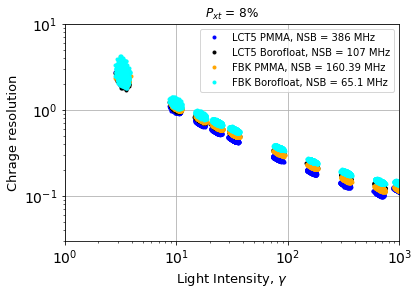

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 386 MHz')
plt.plot(ngamma_hkb_8_fl, q_hkb_8_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 107 MHz')

plt.plot(ngamma_fbk_pmma_8_fl, q_fbk_pmma_8_fl, '.', color = 'orange', label='FBK PMMA, NSB = 160.39 MHz')
plt.plot(ngamma_fbk_8_fl, q_fbk_8_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 65.1 MHz')

#plt.plot(npe_pmt_pmma_fl, q_pmt_pmma_fl, '.', color = 'red', label='PMT PMMA, NSB = 245.8 MHz')

#plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 8%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_Pxt_8.png', dpi=800)
plt.show()

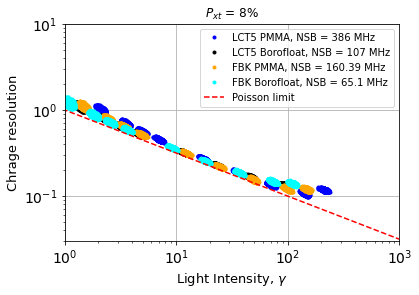

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(npe_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 386 MHz')
plt.plot(npe_hkb_8_fl, q_hkb_8_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 107 MHz')

plt.plot(npe_fbk_pmma_8_fl, q_fbk_pmma_8_fl, '.', color = 'orange', label='FBK PMMA, NSB = 160.39 MHz')
plt.plot(npe_fbk_8_fl, q_fbk_8_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 65.1 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 8%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_Pxt_8.png', dpi=800)
plt.show()

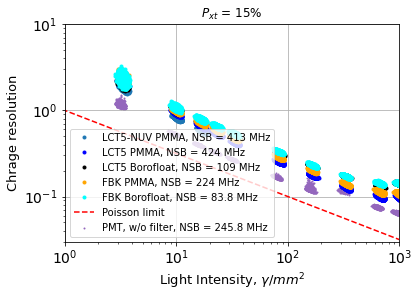

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_hkb_nuv_pmma_15_fl, q_hkb_nuv_pmma_15_fl, '.', label='LCT5-NUV PMMA, NSB = 413 MHz')
plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
plt.plot(ngamma_hkb_15_fl, q_hkb_15_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 109 MHz')

plt.plot(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl, '.', color = 'orange', label='FBK PMMA, NSB = 224 MHz')
plt.plot(ngamma_fbk_15_fl, q_fbk_15_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 83.8 MHz')

plt.scatter(ngamma_pmt_pmma_fl/4, q_pmt_pmma_fl, alpha=1, s=1, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $\gamma/mm^{2}$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_gammas_Pxt_15.png', dpi=800)
plt.show()

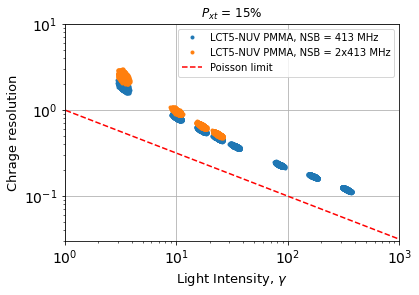

In [45]:
#plt.plot(ngamma_hkb_nuv_15_fl, q_hkb_nuv_15_fl, '.', label='LCT5-NUV Borofloat, NSB = 111 MHz')
#plt.plot(ngamma_hkb_nuv_2x_15_fl, q_hkb_nuv_2x_15_fl, '.', label='LCT5-NUV Borofloat, NSB = 2x111 MHz')
plt.plot(ngamma_hkb_nuv_pmma_15_fl, q_hkb_nuv_pmma_15_fl, '.', label='LCT5-NUV PMMA, NSB = 413 MHz')
plt.plot(ngamma_hkb_nuv_2x_pmma_15_fl, q_hkb_nuv_2x_pmma_15_fl, '.', label='LCT5-NUV PMMA, NSB = 2x413 MHz')
#plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
#plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')

#plt.plot(ngamma_hkb_nuv_nir_2x_pmma_15_fl, q_hkb_nuv_nir_2x_pmma_15_fl, '.', label='LCT5-NUV-NIR PMMA, NSB = 2x305 MHz')
#plt.plot(ngamma_hkb_nuv_nir_pmma_15_fl, q_hkb_nuv_nir_pmma_15_fl, '.', label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.show()

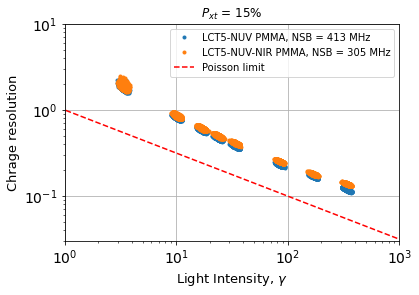

In [82]:
#plt.plot(ngamma_hkb_nuv_15_fl, q_hkb_nuv_15_fl, '.', alpha=0.5, label='LCT5-NUV Borofloat, NSB = 111 MHz')
#plt.plot(ngamma_hkb_nuv_2x_15_fl, q_hkb_nuv_2x_15_fl, '.', label='LCT5-NUV Borofloat, NSB = 2x111 MHz')
plt.plot(ngamma_hkb_nuv_pmma_15_fl, q_hkb_nuv_pmma_15_fl, '.', label='LCT5-NUV PMMA, NSB = 413 MHz')
#plt.plot(ngamma_hkb_nuv_2x_pmma_15_fl, q_hkb_nuv_2x_pmma_15_fl, '.', label='LCT5-NUV PMMA, NSB = 2x413 MHz')
#plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
#plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')

#plt.plot(ngamma_hkb_nuv_nir_2x_pmma_15_fl, q_hkb_nuv_nir_2x_pmma_15_fl, '.', label='LCT5-NUV-NIR PMMA, NSB = 2x305 MHz')
plt.plot(ngamma_hkb_nuv_nir_pmma_15_fl, q_hkb_nuv_nir_pmma_15_fl, '.',  label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.show()

In [56]:
len(cr_hkb_nuv_15[0])

7987

In [64]:
np.mean(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1)

array([  3.40766239,  10.22456533,  17.04394554,  23.86173077,
        34.07648267,  85.21944532, 170.43571191, 340.73788598])

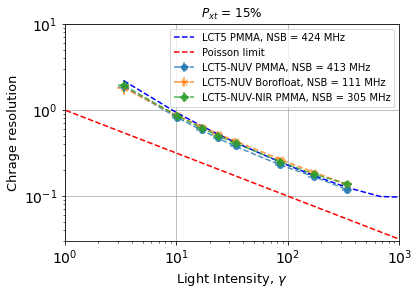

In [108]:
plt.errorbar(np.mean(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1), np.mean(cr_hkb_nuv_pmma_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_pmma_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1), fmt='o--',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 413 MHz')

plt.errorbar(np.mean(np.array(npe_hkb_nuv_15)/pde_hkb_nuv_borofloat_15, axis = 1), np.mean(cr_hkb_nuv_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_15)/pde_hkb_nuv_borofloat_15, axis = 1), fmt='x--', alpha = 0.8, label='LCT5-NUV Borofloat, NSB = 111 MHz')

plt.errorbar(np.mean(np.array(npe_hkb_nuv_nir_pmma_15)/pde_hkb_nuv_nir_pmma_15, axis = 1), np.mean(cr_hkb_nuv_nir_pmma_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_nir_pmma_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_nir_pmma_15)/pde_hkb_nuv_nir_pmma_15, axis = 1), fmt='D--', alpha = 0.8, label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

plt.plot(np.mean(np.array(npe_hkb_pmma_15)/pde_hkb_pmma_15, axis = 1), np.mean(cr_hkb_pmma_15, axis=1), '--', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('cr_nuv.png', dpi=600)
plt.show()

In [121]:
ngamma_hkb_nuv_pmma_15_mean = np.mean(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1)
ngamma_hkb_nuv_pmma_15_std = np.std(np.array(npe_hkb_nuv_pmma_15)/pde_hkb_nuv_pmma_15, axis = 1)
cr_hkb_nuv_pmma_15_mean = np.mean(cr_hkb_nuv_pmma_15, axis=1)
cr_hkb_nuv_pmma_15_std = np.std(cr_hkb_nuv_pmma_15, axis=1)

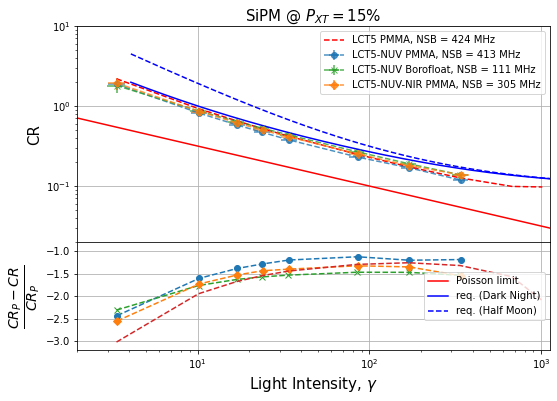

In [28]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-3.2, -0.8), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []



ax1.errorbar(ngamma_hkb_nuv_pmma_15_mean, cr_hkb_nuv_pmma_15_mean, yerr = 3.*cr_hkb_nuv_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_pmma_15_std, fmt='o--', color = 'tab:blue',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 413 MHz')
ax1.errorbar(ngamma_hkb_nuv_15_mean, cr_hkb_nuv_15_mean, yerr = 3.*cr_hkb_nuv_15_std, xerr = 3.*ngamma_hkb_nuv_15_std, fmt='x--', alpha = 0.8, color = 'tab:green', label='LCT5-NUV Borofloat, NSB = 111 MHz')

ax1.errorbar(ngamma_hkb_nuv_nir_pmma_15_mean, cr_hkb_nuv_nir_pmma_15_mean, yerr = 3.*cr_hkb_nuv_nir_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_nir_pmma_15_std, fmt='D--', alpha = 0.8, color = 'tab:orange', label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

ax1.plot(ngamma_hkb_pmma_15_mean, cr_hkb_pmma_15_mean, '--', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '-r')
ax1.plot(gamma_req, cr_req, '-b')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--b')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [4,5,6]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=5)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.plot(ngamma_hkb_nuv_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean) - cr_hkb_nuv_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean)), 'o--', color = 'tab:blue')
ax2.plot(ngamma_hkb_nuv_15_mean, (1./np.sqrt(ngamma_hkb_nuv_15_mean) - cr_hkb_nuv_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_15_mean)), 'x--', color = 'tab:green')
ax2.plot(ngamma_hkb_nuv_nir_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_nir_pmma_15_mean) - cr_hkb_nuv_nir_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_nir_pmma_15_mean)), 'D--', color = 'tab:orange')
ax2.plot(ngamma_hkb_pmma_15_mean, (1./np.sqrt(ngamma_hkb_pmma_15_mean) - cr_hkb_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_pmma_15_mean)), '--', color = 'tab:red')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P} - CR}{CR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15.png')

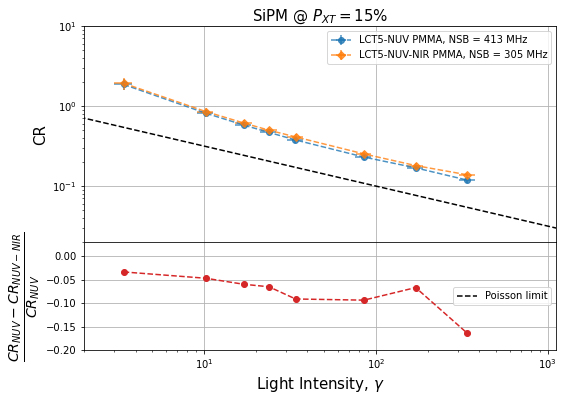

In [66]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.20, 0.03), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []



ax1.errorbar(ngamma_hkb_nuv_pmma_15_mean, cr_hkb_nuv_pmma_15_mean, yerr = 3.*cr_hkb_nuv_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_pmma_15_std, fmt='o--', color = 'tab:blue',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 413 MHz')

#ax1.errorbar(ngamma_hkb_nuv_15_mean, cr_hkb_nuv_15_mean, yerr = 3.*cr_hkb_nuv_15_std, xerr = 3.*ngamma_hkb_nuv_15_std, fmt='x--', alpha = 0.8, color = 'tab:green', label='LCT5-NUV Borofloat, NSB = 111 MHz')

ax1.errorbar(ngamma_hkb_nuv_nir_pmma_15_mean, cr_hkb_nuv_nir_pmma_15_mean, yerr = 3.*cr_hkb_nuv_nir_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_nir_pmma_15_std, fmt='D--', alpha = 0.8, color = 'tab:orange', label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

#ax1.plot(ngamma_hkb_pmma_15_mean, cr_hkb_pmma_15_mean, '--', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--', c= 'black')
#ax1.plot(gamma_req, cr_req, '-b')
#ax1.plot(gamma_req_nsb, cr_req_nsb, '--b')

lines = ax1.get_lines()
#legend = pyplot.legend([lines[i] for i in [4,5,6]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=5)

legend = pyplot.legend([lines[i] for i in [2]], ["Poisson limit"], loc=5)


#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

#ax2.plot(ngamma_hkb_nuv_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean) - cr_hkb_nuv_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean)), 'o--', color = 'tab:blue')
#ax2.plot(ngamma_hkb_nuv_15_mean, (1./np.sqrt(ngamma_hkb_nuv_15_mean) - cr_hkb_nuv_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_15_mean)), 'x--', color = 'tab:green')
#ax2.plot(ngamma_hkb_nuv_nir_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_nir_pmma_15_mean) - cr_hkb_nuv_nir_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_nir_pmma_15_mean)), 'D--', color = 'tab:orange')
#ax2.plot(ngamma_hkb_pmma_15_mean, (1./np.sqrt(ngamma_hkb_pmma_15_mean) - cr_hkb_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_pmma_15_mean)), '--', color = 'tab:red')

ax2.plot(ngamma_hkb_nuv_nir_pmma_15_mean, (cr_hkb_nuv_pmma_15_mean - cr_hkb_nuv_nir_pmma_15_mean)/cr_hkb_nuv_pmma_15_mean, 'o--', color = 'tab:red')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{NUV} - CR_{NUV-NIR}}{CR_{NUV}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15.png')

In [40]:
(cr_hkb_nuv_pmma_15_mean - cr_hkb_nuv_nir_pmma_15_mean)

array([-0.06280689, -0.03847211, -0.03471557, -0.03060713, -0.03442634,
       -0.02163147, -0.01132791, -0.01951778])

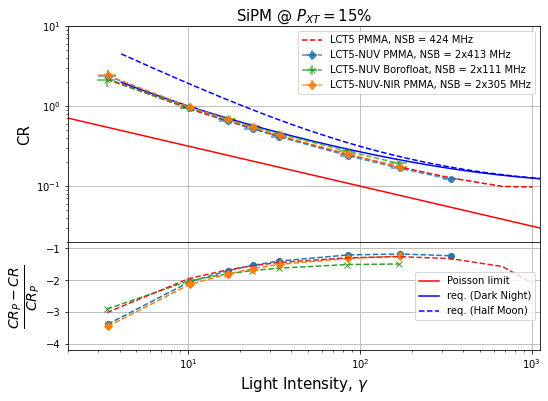

In [39]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-4.2, -0.8), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []



ax1.errorbar(ngamma_hkb_nuv_2x_pmma_15_mean, cr_hkb_nuv_2x_pmma_15_mean, yerr = 3.*cr_hkb_nuv_2x_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_2x_pmma_15_std, fmt='o--', color = 'tab:blue',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 2x413 MHz')

ax1.errorbar(ngamma_hkb_nuv_2x_15_mean, cr_hkb_nuv_2x_15_mean, yerr = 3.*cr_hkb_nuv_2x_15_std, 
             xerr = 3.*ngamma_hkb_nuv_2x_15_std, fmt='x--', alpha = 0.8, color = 'tab:green', label='LCT5-NUV Borofloat, NSB = 2x111 MHz')

ax1.errorbar(ngamma_hkb_nuv_nir_2x_pmma_15_mean, cr_hkb_nuv_nir_2x_pmma_15_mean, yerr = 3.*cr_hkb_nuv_nir_2x_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_nir_2x_pmma_15_std, fmt='D--', alpha = 0.8, color = 'tab:orange', label='LCT5-NUV-NIR PMMA, NSB = 2x305 MHz')

ax1.plot(ngamma_hkb_pmma_15_mean, cr_hkb_pmma_15_mean, '--', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '-r')
ax1.plot(gamma_req, cr_req, '-b')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--b')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [4,5,6]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=5)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.plot(ngamma_hkb_nuv_2x_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_2x_pmma_15_mean) - cr_hkb_nuv_2x_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_2x_pmma_15_mean)), 'o--', color = 'tab:blue')
ax2.plot(ngamma_hkb_nuv_2x_15_mean, (1./np.sqrt(ngamma_hkb_nuv_2x_15_mean) - cr_hkb_nuv_2x_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_2x_15_mean)), 'x--', color = 'tab:green')
ax2.plot(ngamma_hkb_nuv_nir_2x_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_nir_2x_pmma_15_mean) - cr_hkb_nuv_nir_2x_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_nir_2x_pmma_15_mean)), 'D--', color = 'tab:orange')
ax2.plot(ngamma_hkb_pmma_15_mean, (1./np.sqrt(ngamma_hkb_pmma_15_mean) - cr_hkb_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_pmma_15_mean)), '--', color = 'tab:red')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P} - CR}{CR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15_2x.png')

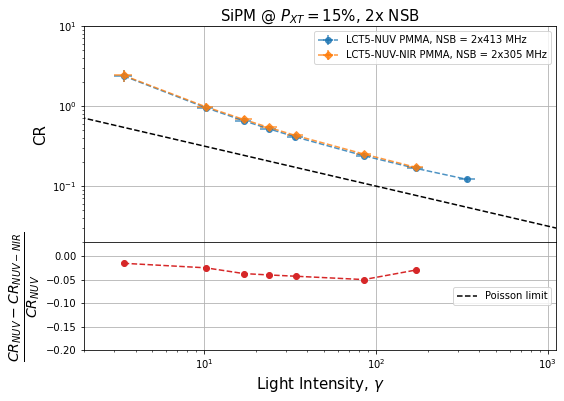

In [67]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.2, 0.03), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []



ax1.errorbar(ngamma_hkb_nuv_2x_pmma_15_mean, cr_hkb_nuv_2x_pmma_15_mean, yerr = 3.*cr_hkb_nuv_2x_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_2x_pmma_15_std, fmt='o--', color = 'tab:blue',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 2x413 MHz')

#ax1.errorbar(ngamma_hkb_nuv_2x_15_mean, cr_hkb_nuv_2x_15_mean, yerr = 3.*cr_hkb_nuv_2x_15_std, 
#             xerr = 3.*ngamma_hkb_nuv_2x_15_std, fmt='x--', alpha = 0.8, color = 'tab:green', label='LCT5-NUV Borofloat, NSB = 2x111 MHz')

ax1.errorbar(ngamma_hkb_nuv_nir_2x_pmma_15_mean, cr_hkb_nuv_nir_2x_pmma_15_mean, yerr = 3.*cr_hkb_nuv_nir_2x_pmma_15_std, 
             xerr = 3.*ngamma_hkb_nuv_nir_2x_pmma_15_std, fmt='D--', alpha = 0.8, color = 'tab:orange', label='LCT5-NUV-NIR PMMA, NSB = 2x305 MHz')

#ax1.plot(ngamma_hkb_pmma_15_mean, cr_hkb_pmma_15_mean, '--', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--', c = 'black')
#ax1.plot(gamma_req, cr_req, '-b')
#ax1.plot(gamma_req_nsb, cr_req_nsb, '--b')

lines = ax1.get_lines()
#legend = pyplot.legend([lines[i] for i in [4,5,6]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=5)

legend = pyplot.legend([lines[i] for i in [2]], ["Poisson limit"], loc=5)


#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'SiPM @ $P_{XT} = 15 \%$, 2x NSB',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

#ax2.plot(ngamma_hkb_nuv_2x_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_2x_pmma_15_mean) - cr_hkb_nuv_2x_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_2x_pmma_15_mean)), 'o--', color = 'tab:blue')
#ax2.plot(ngamma_hkb_nuv_2x_15_mean, (1./np.sqrt(ngamma_hkb_nuv_2x_15_mean) - cr_hkb_nuv_2x_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_2x_15_mean)), 'x--', color = 'tab:green')
#ax2.plot(ngamma_hkb_nuv_nir_2x_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_nir_2x_pmma_15_mean) - cr_hkb_nuv_nir_2x_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_nir_2x_pmma_15_mean)), 'D--', color = 'tab:orange')
#ax2.plot(ngamma_hkb_pmma_15_mean, (1./np.sqrt(ngamma_hkb_pmma_15_mean) - cr_hkb_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_pmma_15_mean)), '--', color = 'tab:red')

ax2.plot(ngamma_hkb_nuv_nir_2x_pmma_15_mean, (cr_hkb_nuv_2x_pmma_15_mean[:-1] - cr_hkb_nuv_nir_2x_pmma_15_mean)/cr_hkb_nuv_2x_pmma_15_mean[:-1], 'o--', color = 'tab:red')


ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{NUV} - CR_{NUV-NIR}}{CR_{NUV}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15_2x.png')

In [57]:
len(cr_hkb_nuv_2x_pmma_15_mean)

8

In [127]:
(1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean) - cr_hkb_nuv_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean))

array([-2.43484512, -1.60710741, -1.3873146 , -1.28781208, -1.20021611,
       -1.12794523, -1.20522141, -1.18993946])

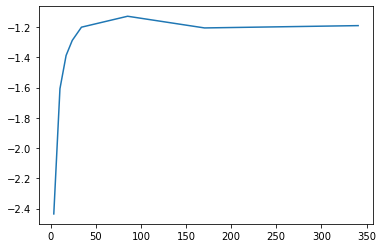

In [128]:
plt.plot(ngamma_hkb_nuv_pmma_15_mean, (1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean) - cr_hkb_nuv_pmma_15_mean)/(1./np.sqrt(ngamma_hkb_nuv_pmma_15_mean)))

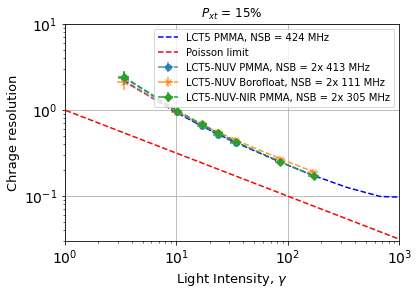

In [109]:
plt.errorbar(np.mean(np.array(npe_hkb_nuv_2x_pmma_15)/pde_hkb_nuv_2x_pmma_15, axis = 1), np.mean(cr_hkb_nuv_2x_pmma_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_2x_pmma_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_2x_pmma_15)/pde_hkb_nuv_2x_pmma_15, axis = 1), fmt='o--',  alpha = 0.8, label='LCT5-NUV PMMA, NSB = 2x 413 MHz')

plt.errorbar(np.mean(np.array(npe_hkb_nuv_2x_15)/pde_hkb_nuv_2x_borofloat_15, axis = 1), np.mean(cr_hkb_nuv_2x_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_2x_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_2x_15)/pde_hkb_nuv_2x_borofloat_15, axis = 1), fmt='x--', alpha = 0.8, label='LCT5-NUV Borofloat, NSB = 2x 111 MHz')

plt.errorbar(np.mean(np.array(npe_hkb_nuv_nir_2x_pmma_15)/pde_hkb_nuv_nir_2x_pmma_15, axis = 1), np.mean(cr_hkb_nuv_nir_2x_pmma_15, axis=1), yerr = 3.*np.std(cr_hkb_nuv_nir_2x_pmma_15, axis=1), 
             xerr = 3.*np.std(np.array(npe_hkb_nuv_nir_2x_pmma_15)/pde_hkb_nuv_nir_2x_pmma_15, axis = 1), fmt='D--', label='LCT5-NUV-NIR PMMA, NSB = 2x 305 MHz')

plt.plot(np.mean(np.array(npe_hkb_pmma_15)/pde_hkb_pmma_15, axis = 1), np.mean(cr_hkb_pmma_15, axis=1), '--', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('cr_nuv_2x.png', dpi=600)
plt.show()

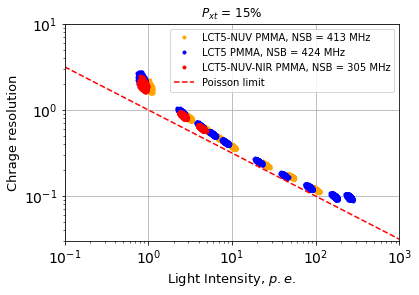

In [37]:
plt.plot(npe_hkb_nuv_pmma_15_fl, q_hkb_nuv_pmma_15_fl, '.', color = 'orange', label='LCT5-NUV PMMA, NSB = 413 MHz')
plt.plot(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
plt.plot(npe_hkb_nuv_nir_pmma_15_fl, q_hkb_nuv_nir_pmma_15_fl, '.', color = 'red', label='LCT5-NUV-NIR PMMA, NSB = 305 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([0.1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel('Light Intensity, $p.e.$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.show()

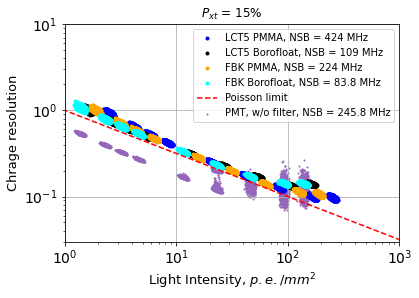

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
plt.plot(npe_hkb_15_fl, q_hkb_15_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 109 MHz')

plt.plot(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl, '.', color = 'orange', label='FBK PMMA, NSB = 224 MHz')
plt.plot(npe_fbk_15_fl, q_fbk_15_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 83.8 MHz')

plt.scatter(npe_pmt_pmma_fl/4, q_pmt_pmma_fl, alpha=1, s=1, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 15%')
plt.xlabel(r'Light Intensity, $p.e./mm^{2}$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_pe_Pxt_15.png', dpi=800)
plt.show()

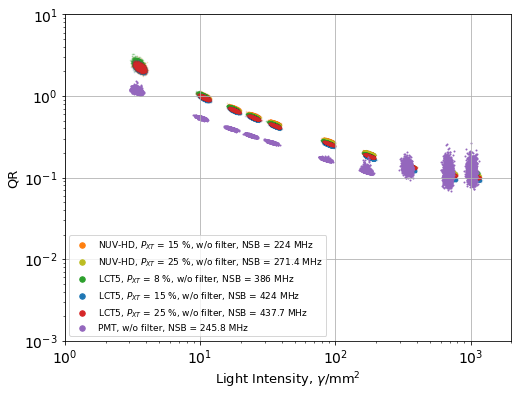

In [37]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.scatter(ngamma_fbk_pmma_15_fl/0.936, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:orange', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_pmma_25_fl/0.936, q_fbk_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='NUV-HD, $P_{XT}$ = 25 %, w/o filter, NSB = 271.4 MHz')
ax1.scatter(ngamma_hkb_pmma_8_fl/0.936, q_hkb_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:green',  label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 386 MHz')
ax1.scatter(ngamma_hkb_pmma_15_fl/0.936, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(ngamma_hkb_pmma_25_fl/0.936, q_hkb_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 437.7 MHz')

ax1.scatter(ngamma_pmt_pmma_fl/(4*0.936), q_pmt_pmma_fl, alpha=1, s=1, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')

#plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.001, 10])
plt.xlim([1, 2000])

lgnd = ax1.legend(fontsize=9, loc = 3)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

#plt.title('$P_{xt}$ = 15%')
plt.xlabel(r'Light Intensity, $\gamma$/mm$^{2}$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('QR',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_.png', dpi=800)
plt.show()

In [ ]:
ax1.scatter(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:orange', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='NUV-HD, $P_{XT}$ = 25 %, w/o filter, NSB = 271.4 MHz')
ax1.scatter(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:green',  label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 386 MHz')
ax1.scatter(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 437.7 MHz')


In [62]:
245.8*1.60217*0.646/0.936

271.7985548675214

In [ ]:
61/1.60217

In [64]:
0.936*27./(0.646*1.6)

24.45046439628483

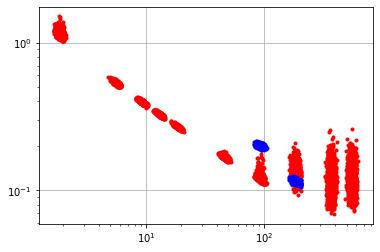

In [38]:
plt.plot(npe_pmt_pmma_fl, q_pmt_pmma_fl, '.', color = 'red', label='PMT PMMA, NSB = 245.8 MHz')
plt.plot(npe_pmt_lg_pmma_fl, q_pmt_lg_pmma_fl, '.', color = 'blue', label='PMT PMMA, NSB = 245.8 MHz')
plt.xscale('log')
plt.yscale('log')
plt.grid()

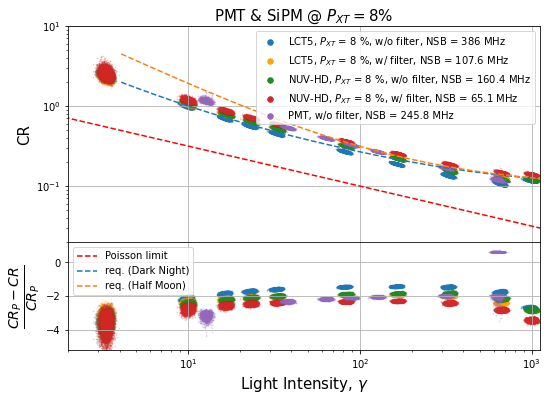

In [28]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-5.2, 1.2), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []

ax1.scatter(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 386 MHz')
ax1.scatter(ngamma_hkb_8_fl, q_hkb_8_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 8 %, w/ filter, NSB = 107.6 MHz')

ax1.scatter(ngamma_fbk_pmma_8_fl, q_fbk_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 8 %, w/o filter, NSB = 160.4 MHz')
ax1.scatter(ngamma_fbk_8_fl, q_fbk_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='NUV-HD, $P_{XT}$ = 8 %, w/ filter, NSB = 65.1 MHz')
ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'PMT & SiPM @ $P_{XT} = 8 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_hkb_pmma_8_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl)) - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_8_fl, (1./np.sqrt(np.array(ngamma_hkb_8_fl)) - np.array(q_hkb_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_8_fl))), alpha=lambda_plot, color = 'orange', s=point_size,)
ax2.scatter(ngamma_fbk_pmma_8_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl)) - np.array(q_fbk_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_8_fl, (1./np.sqrt(np.array(ngamma_fbk_8_fl)) - np.array(q_fbk_8_fl))/(1./np.sqrt(np.array(ngamma_fbk_8_fl))), alpha=lambda_plot, color = 'tab:red',  s=point_size,)

ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P} - CR}{CR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_8.png')

In [323]:
len(lgnd.legendHandles)

5

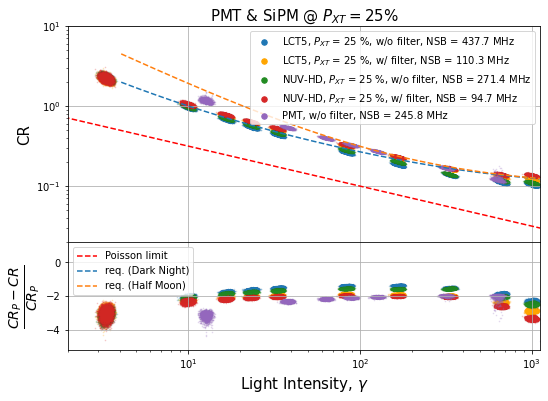

In [42]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-5.2, 1.2), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []

ax1.scatter(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 437.7 MHz')
ax1.scatter(ngamma_hkb_25_fl, q_hkb_25_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 25 %, w/ filter, NSB = 110.3 MHz')

ax1.scatter(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 25 %, w/o filter, NSB = 271.4 MHz')
ax1.scatter(ngamma_fbk_25_fl, q_fbk_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='NUV-HD, $P_{XT}$ = 25 %, w/ filter, NSB = 94.7 MHz')
ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'PMT & SiPM @ $P_{XT} = 25 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.legend(loc=1)

lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_hkb_pmma_25_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_25_fl, (1./np.sqrt(np.array(ngamma_hkb_25_fl)) - np.array(q_hkb_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_25_fl))), alpha=lambda_plot, color = 'orange', s=point_size,)
ax2.scatter(ngamma_fbk_pmma_25_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_25_fl)) - np.array(q_fbk_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_25_fl))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_25_fl, (1./np.sqrt(np.array(ngamma_fbk_25_fl)) - np.array(q_fbk_25_fl))/(1./np.sqrt(np.array(ngamma_fbk_25_fl))), alpha=lambda_plot, color = 'tab:red',  s=point_size,)

ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P} - CR}{CR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_25.png')

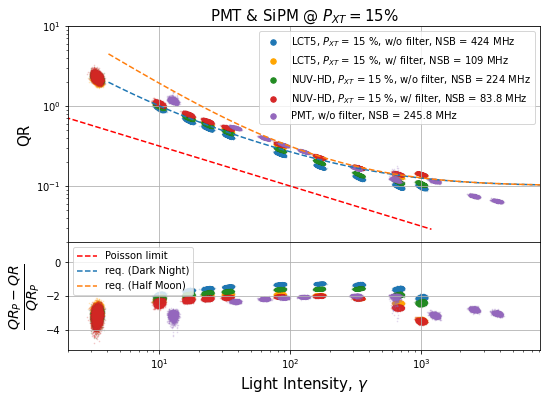

In [52]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 8120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-5.2, 1.2), xlim=(2, 8120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('QR',  fontsize=15)

plot_lines = []
plot_lines2 = []

pmt_area = 16.24
sipm_area = 4.67


norm_coef_pmt = math.sqrt(pmt_area)
norm_coef_sipm = math.sqrt(sipm_area)

ax1.scatter(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(ngamma_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

ax1.scatter(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')
ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')

ngamma_req = np.arange(gamma_req[0], gamma_req[-1], 1)
f_requirments = interp1d(gamma_req, cr_req, kind='cubic')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'PMT & SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_hkb_pmma_15_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_15_fl, (1./np.sqrt(np.array(ngamma_hkb_15_fl)) - np.array(q_hkb_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_15_fl))), alpha=lambda_plot, color = 'orange', s=point_size,)
ax2.scatter(ngamma_fbk_pmma_15_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl)) - np.array(q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_15_fl, (1./np.sqrt(np.array(ngamma_fbk_15_fl)) - np.array(q_fbk_15_fl))/(1./np.sqrt(np.array(ngamma_fbk_15_fl))), alpha=lambda_plot, color = 'tab:red',  s=point_size,)

ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_hkb_pmma_15_fl, (f_requirments(ngamma_hkb_pmma_15_fl) -  q_pmt_pmma_fl)/f_requirments(ngamma_hkb_pmma_15_fl), color = 'tab:blue', alpha=lambda_plot, s=point_size,)


ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{QR_{P} - QR}{QR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15.png')

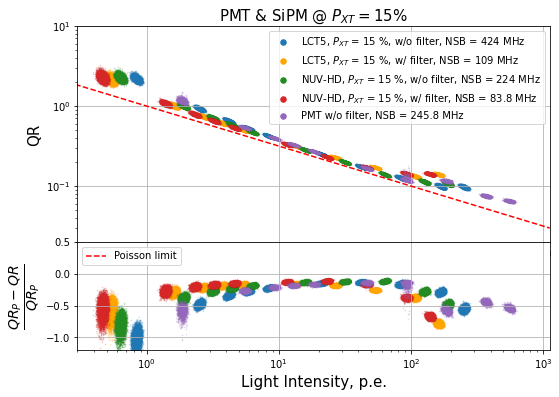

In [53]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(0.3, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-1.2, 0.5), xlim=(0.3, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('QR',  fontsize=15)

plot_lines = []
plot_lines2 = []

ax1.scatter(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue', label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')
ax1.scatter(npe_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT w/o filter, NSB = 245.8 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
#ax1.plot(gamma_req, cr_req, '--')
#ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0]], ["Poisson limit"], loc=2)

ax1.set_title(r'PMT & SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(npe_hkb_pmma_15_fl, (1./np.sqrt(np.array(npe_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(npe_hkb_15_fl, (1./np.sqrt(np.array(npe_hkb_15_fl)) - np.array(q_hkb_15_fl))/(1./np.sqrt(np.array(npe_hkb_15_fl))), color = 'orange', alpha=lambda_plot, s=point_size,)
ax2.scatter(npe_fbk_pmma_15_fl, (1./np.sqrt(np.array(npe_fbk_pmma_15_fl)) - np.array(q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(npe_fbk_pmma_15_fl))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(npe_fbk_15_fl, (1./np.sqrt(np.array(npe_fbk_15_fl)) - np.array(q_fbk_15_fl))/(1./np.sqrt(np.array(npe_fbk_15_fl))), color = 'tab:red', alpha=lambda_plot, s=point_size,)

ax2.scatter(npe_pmt_pmma_fl, (1./np.sqrt(np.array(npe_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(npe_pmt_pmma_fl))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{QR_{P} - QR}{QR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, p.e.',  fontsize=15)

fig.savefig('charge_resolution_pe_Pxt_15.png')

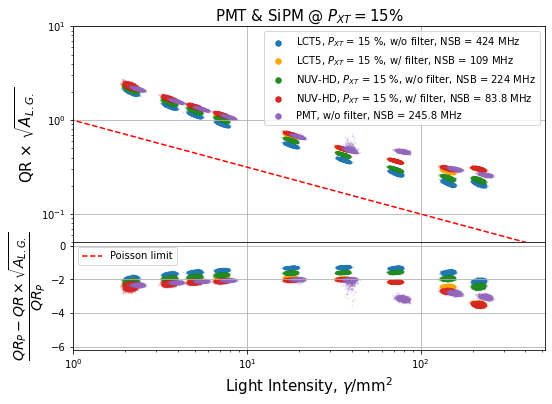

In [58]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.05, 10), xlim=(1, 520))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-6.2, 0.2), xlim=(1, 520))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel(r'QR $\times \ \sqrt{A_{L.G.}}$',  fontsize=15)

plot_lines = []
plot_lines2 = []

pmt_area = 16.24
sipm_area = 4.67


norm_coef_pmt = math.sqrt(pmt_area)
norm_coef_sipm = math.sqrt(sipm_area)

ax1.scatter(ngamma_hkb_pmma_15_fl/sipm_area, norm_coef_sipm*q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(ngamma_hkb_15_fl/sipm_area, norm_coef_sipm*q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

ax1.scatter(ngamma_fbk_pmma_15_fl/sipm_area, norm_coef_sipm*q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_15_fl/sipm_area, norm_coef_sipm*q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')
ax1.scatter(ngamma_pmt_pmma_fl/pmt_area, norm_coef_pmt*q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')
#ax1.scatter(ngamma_pmt_lg_pmma_fl/pmt_area, norm_coef_pmt*q_pmt_lg_pmma_fl, alpha=lambda_plot, s=point_size, label='PMT, w/o filter, low gain, NSB = 245.8 MHz')

ngamma_req = np.arange(gamma_req[0], gamma_req[-1], 1)
f_requirments = interp1d(gamma_req, cr_req, kind='cubic')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
#ax1.plot(gamma_req, cr_req, '--')
#ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
#legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)
legend = pyplot.legend([lines[i] for i in [0]], ["Poisson limit"], loc=2)


#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'PMT & SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

ax1.axes.xaxis.set_ticklabels([])
#ax1.axis['bottom'].set_visible(False)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_hkb_pmma_15_fl/sipm_area, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl/sipm_area))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_15_fl/sipm_area, (1./np.sqrt(np.array(ngamma_hkb_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_hkb_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_15_fl/sipm_area))), alpha=lambda_plot, color = 'orange', s=point_size,)
ax2.scatter(ngamma_fbk_pmma_15_fl/sipm_area, (1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl/sipm_area))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_15_fl/sipm_area, (1./np.sqrt(np.array(ngamma_fbk_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_fbk_15_fl))/(1./np.sqrt(np.array(ngamma_fbk_15_fl/sipm_area))), alpha=lambda_plot, color = 'tab:red',  s=point_size,)

ax2.scatter(ngamma_pmt_pmma_fl/pmt_area, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl/pmt_area)) - np.array(norm_coef_pmt*q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl/pmt_area))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_hkb_pmma_15_fl, (f_requirments(ngamma_hkb_pmma_15_fl) -  q_pmt_pmma_fl)/f_requirments(ngamma_hkb_pmma_15_fl), color = 'tab:blue', alpha=lambda_plot, s=point_size,)


ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{QR_{P} - QR \times \sqrt{A_{L.G.}} }{QR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$/mm$^{2}$',  fontsize=15)

fig.savefig('charge_resolution_gammas_Pxt_15_nortm_LG.png')

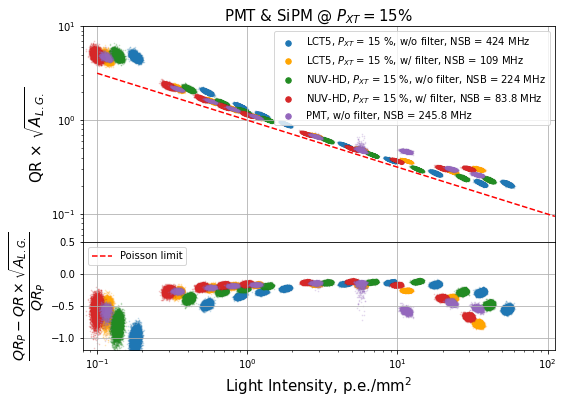

In [57]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.05, 10), xlim=(0.08, 112))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-1.2, 0.5), xlim=(0.08, 112))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel(r'QR $\times \ \sqrt{A_{L.G.}}$',  fontsize=15)

plot_lines = []
plot_lines2 = []

pmt_area = 16.24
sipm_area = 4.67


norm_coef_pmt = math.sqrt(pmt_area)
norm_coef_sipm = math.sqrt(sipm_area)

ax1.scatter(npe_hkb_pmma_15_fl/sipm_area, norm_coef_sipm*q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(npe_hkb_15_fl/sipm_area, norm_coef_sipm*q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

ax1.scatter(npe_fbk_pmma_15_fl/sipm_area, norm_coef_sipm*q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(npe_fbk_15_fl/sipm_area, norm_coef_sipm*q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')
ax1.scatter(npe_pmt_pmma_fl/pmt_area, norm_coef_pmt*q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')

ngamma_req = np.arange(gamma_req[0], gamma_req[-1], 1)
f_requirments = interp1d(gamma_req, cr_req, kind='cubic')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
#ax1.plot(gamma_req, cr_req, '--')
#ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
#legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)
legend = pyplot.legend([lines[i] for i in [0]], ["Poisson limit"], loc=2)


#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title(r'PMT & SiPM @ $P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(npe_hkb_pmma_15_fl/sipm_area, (1./np.sqrt(np.array(npe_hkb_pmma_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_15_fl/sipm_area))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(npe_hkb_15_fl/sipm_area, (1./np.sqrt(np.array(npe_hkb_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_hkb_15_fl))/(1./np.sqrt(np.array(npe_hkb_15_fl/sipm_area))), alpha=lambda_plot, color = 'orange', s=point_size,)
ax2.scatter(npe_fbk_pmma_15_fl/sipm_area, (1./np.sqrt(np.array(npe_fbk_pmma_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(npe_fbk_pmma_15_fl/sipm_area))), color = 'forestgreen', alpha=lambda_plot, s=point_size,)
ax2.scatter(npe_fbk_15_fl/sipm_area, (1./np.sqrt(np.array(npe_fbk_15_fl/sipm_area)) - np.array(norm_coef_sipm*q_fbk_15_fl))/(1./np.sqrt(np.array(npe_fbk_15_fl/sipm_area))), alpha=lambda_plot, color = 'tab:red',  s=point_size,)

ax2.scatter(npe_pmt_pmma_fl/pmt_area, (1./np.sqrt(np.array(npe_pmt_pmma_fl/pmt_area)) - np.array(norm_coef_pmt*q_pmt_pmma_fl))/(1./np.sqrt(np.array(npe_pmt_pmma_fl/pmt_area))), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_hkb_pmma_15_fl, (f_requirments(ngamma_hkb_pmma_15_fl) -  q_pmt_pmma_fl)/f_requirments(ngamma_hkb_pmma_15_fl), color = 'tab:blue', alpha=lambda_plot, s=point_size,)


ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{QR_{P} - QR \times \sqrt{A_{L.G.}} }{QR_{P}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, p.e./mm$^{2}$',  fontsize=15)

fig.savefig('charge_resolution_pe_Pxt_15_nortm_LG.png')

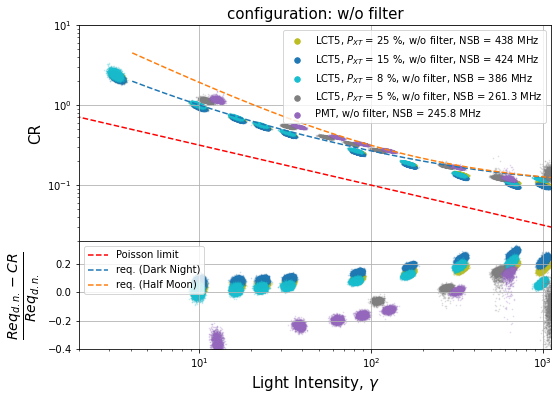

In [56]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.4, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

#ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
#ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')





ax1.scatter(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 438 MHz')
ax1.scatter(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue', label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')

ax1.scatter(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 386 MHz')
ax1.scatter(ngamma_hkb_pmma_5_fl, q_hkb_pmma_5_fl,  alpha=lambda_plot, s=point_size, color = 'tab:gray',  label='LCT5, $P_{XT}$ = 5 %, w/o filter, NSB = 261.3 MHz')

ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple',  label='PMT, w/o filter, NSB = 245.8 MHz')




ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title('configuration: w/o filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

    
ax2.scatter(ngamma_hkb_pmma_25_fl[7987:], (f_requirments(ngamma_hkb_pmma_25_fl[7987:]) - q_hkb_pmma_25_fl[7987:])/f_requirments(ngamma_hkb_pmma_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_15_fl[7987:], (f_requirments(ngamma_hkb_pmma_15_fl[7987:]) - q_hkb_pmma_15_fl[7987:])/f_requirments(ngamma_hkb_pmma_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_8_fl[7987:], (f_requirments(ngamma_hkb_pmma_8_fl[7987:]) - q_hkb_pmma_8_fl[7987:])/f_requirments(ngamma_hkb_pmma_8_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_5_fl[7987:], (f_requirments(ngamma_hkb_pmma_5_fl[7987:]) - q_hkb_pmma_5_fl[7987:])/f_requirments(ngamma_hkb_pmma_5_fl[7987:]), color = 'tab:gray', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_hkb_pmma_25_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl))), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_15_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_8_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl)) - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))), color = 'tab:cyan',alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_5_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl)) - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))), color = 'tab:gray', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_pmt_pmma_fl, (f_requirments(ngamma_pmt_pmma_fl) - q_pmt_pmma_fl)/f_requirments(ngamma_pmt_pmma_fl), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple',  alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - CR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_wo_hkb_filter.png')

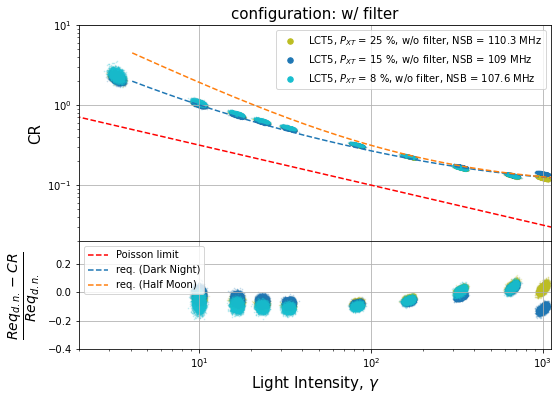

In [29]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.4, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

#ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
#ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')





ax1.scatter(ngamma_hkb_25_fl, q_hkb_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 110.3 MHz')
ax1.scatter(ngamma_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue', label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 109 MHz')

ax1.scatter(ngamma_hkb_8_fl, q_hkb_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 107.6 MHz')
#ax1.scatter(ngamma_hkb_5_fl, q_hkb_5_fl,  alpha=lambda_plot, s=point_size, color = 'tab:gray',  label='LCT5, $P_{XT}$ = 5 %, w/o filter, NSB = 73.4 MHz')



ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title('configuration: w/ filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

    
ax2.scatter(ngamma_hkb_25_fl[7987:], (f_requirments(ngamma_hkb_25_fl[7987:]) - q_hkb_25_fl[7987:])/f_requirments(ngamma_hkb_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_15_fl[7987:], (f_requirments(ngamma_hkb_15_fl[7987:]) - q_hkb_15_fl[7987:])/f_requirments(ngamma_hkb_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_8_fl[7987:], (f_requirments(ngamma_hkb_8_fl[7987:]) - q_hkb_8_fl[7987:])/f_requirments(ngamma_hkb_8_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_5_fl[7987:], (f_requirments(ngamma_hkb_5_fl[7987:]) - q_hkb_5_fl[7987:])/f_requirments(ngamma_hkb_5_fl[7987:]), color = 'tab:gray', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_hkb_pmma_25_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl))), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_15_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_8_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl)) - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))), color = 'tab:cyan',alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_5_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl)) - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))), color = 'tab:gray', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_pmt_pmma_fl, (f_requirments(ngamma_pmt_pmma_fl) - q_pmt_pmma_fl)/f_requirments(ngamma_pmt_pmma_fl), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple',  alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - CR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_w_hkb_filter.png')

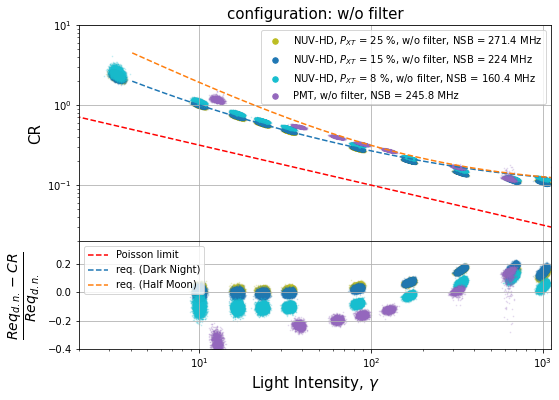

In [30]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.4, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

#ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
#ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')





ax1.scatter(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='NUV-HD, $P_{XT}$ = 25 %, w/o filter, NSB = 271.4 MHz')
ax1.scatter(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_pmma_8_fl, q_fbk_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='NUV-HD, $P_{XT}$ = 8 %, w/o filter, NSB = 160.4 MHz')

ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple',  label='PMT, w/o filter, NSB = 245.8 MHz')




ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title('configuration: w/o filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_fbk_pmma_25_fl[7987:], (f_requirments(ngamma_fbk_pmma_25_fl[7987:]) - q_fbk_pmma_25_fl[7987:])/f_requirments(ngamma_fbk_pmma_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_pmma_15_fl[7987:], (f_requirments(ngamma_fbk_pmma_15_fl[7987:]) - q_fbk_pmma_15_fl[7987:])/f_requirments(ngamma_fbk_pmma_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_pmma_8_fl[7987:], (f_requirments(ngamma_fbk_pmma_8_fl[7987:]) - q_fbk_pmma_8_fl[7987:])/f_requirments(ngamma_fbk_pmma_8_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_fbk_pmma_25_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_25_fl)) - np.array(q_fbk_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_25_fl))), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_fbk_pmma_15_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl)) - np.array(q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_fbk_pmma_8_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl)) - np.array(q_fbk_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl))), color = 'tab:cyan',alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_pmt_pmma_fl, (f_requirments(ngamma_pmt_pmma_fl) - q_pmt_pmma_fl)/f_requirments(ngamma_pmt_pmma_fl), color = 'tab:purple', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple',  alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - CR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_wo_filter_fbk.png')

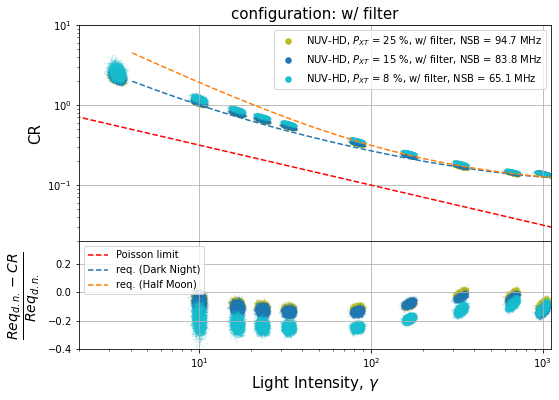

In [31]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.4, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

#ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
#ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')





ax1.scatter(ngamma_fbk_25_fl, q_fbk_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='NUV-HD, $P_{XT}$ = 25 %, w/ filter, NSB = 94.7 MHz')
ax1.scatter(ngamma_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')
ax1.scatter(ngamma_fbk_8_fl, q_fbk_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='NUV-HD, $P_{XT}$ = 8 %, w/ filter, NSB = 65.1 MHz')



ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title('configuration: w/ filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_fbk_25_fl[7987:], (f_requirments(ngamma_fbk_25_fl[7987:]) - q_fbk_25_fl[7987:])/f_requirments(ngamma_fbk_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_15_fl[7987:], (f_requirments(ngamma_fbk_15_fl[7987:]) - q_fbk_15_fl[7987:])/f_requirments(ngamma_fbk_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_8_fl[7987:], (f_requirments(ngamma_fbk_8_fl[7987:]) - q_fbk_8_fl[7987:])/f_requirments(ngamma_fbk_8_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - CR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_w_filter_fbk.png')

In [45]:
ngamma_fbk_pmma_25_fl[1]

3.387062544040718

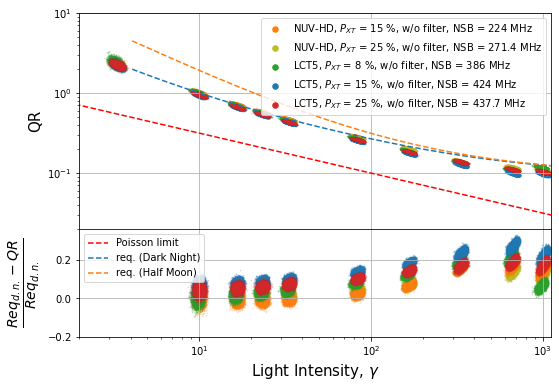

In [21]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.2, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('QR',  fontsize=15)

#ax1.scatter(npe_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'orange', label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

#ax1.scatter(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'forestgreen', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
#ax1.scatter(npe_fbk_15_fl, q_fbk_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red', label='NUV-HD, $P_{XT}$ = 15 %, w/ filter, NSB = 83.8 MHz')





ax1.scatter(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:orange', label='NUV-HD, $P_{XT}$ = 15 %, w/o filter, NSB = 224 MHz')
ax1.scatter(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive', label='NUV-HD, $P_{XT}$ = 25 %, w/o filter, NSB = 271.4 MHz')
ax1.scatter(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:green',  label='LCT5, $P_{XT}$ = 8 %, w/o filter, NSB = 386 MHz')
ax1.scatter(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',  label='LCT5, $P_{XT}$ = 15 %, w/o filter, NSB = 424 MHz')
ax1.scatter(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:red',  label='LCT5, $P_{XT}$ = 25 %, w/o filter, NSB = 437.7 MHz')


#ax1.scatter(ngamma_fbk_pmma_8_fl, q_fbk_pmma_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='NUV-HD, $P_{XT}$ = 8 %, w/o filter, NSB = 160.4 MHz')

#ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple',  label='PMT, w/o filter, NSB = 245.8 MHz')




ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')
f_requirments = interp1d(gamma_req, cr_req, kind='cubic')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
#ax1.set_title('configuration: w/o filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)

ax2.scatter(ngamma_fbk_pmma_25_fl[7987:], (f_requirments(ngamma_fbk_pmma_25_fl[7987:]) - q_fbk_pmma_25_fl[7987:])/f_requirments(ngamma_fbk_pmma_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_fbk_pmma_15_fl[7987:], (f_requirments(ngamma_fbk_pmma_15_fl[7987:]) - q_fbk_pmma_15_fl[7987:])/f_requirments(ngamma_fbk_pmma_15_fl[7987:]), color = 'tab:orange', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_8_fl[7987:], (f_requirments(ngamma_hkb_pmma_8_fl[7987:]) - q_hkb_pmma_8_fl[7987:])/f_requirments(ngamma_hkb_pmma_8_fl[7987:]), color = 'tab:green', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_15_fl[7987:], (f_requirments(ngamma_hkb_pmma_15_fl[7987:]) - q_hkb_pmma_15_fl[7987:])/f_requirments(ngamma_hkb_pmma_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_pmma_25_fl[7987:], (f_requirments(ngamma_hkb_pmma_25_fl[7987:]) - q_hkb_pmma_25_fl[7987:])/f_requirments(ngamma_hkb_pmma_25_fl[7987:]), color = 'tab:red', alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_fbk_pmma_8_fl, (1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl)) - np.array(q_fbk_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_fbk_pmma_8_fl))), color = 'tab:cyan',alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), color = 'tab:purple',  alpha=lambda_plot, s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - QR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_requirments.png')

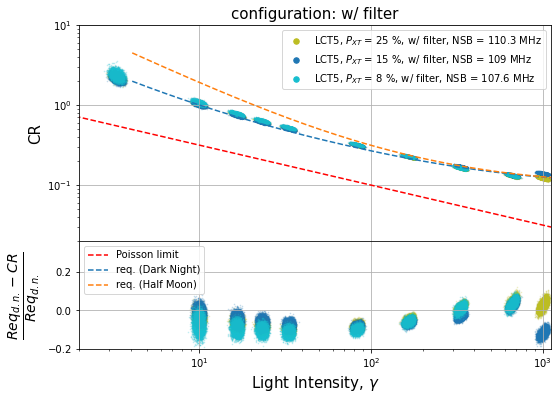

In [103]:
from matplotlib import pyplot

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.25],
                   ylim=(-0.2, 0.36), xlim=(2, 1120))

x = np.linspace(0, 2000)

lambda_plot = 0.2
point_size = 0.5

ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

plot_lines = []
plot_lines2 = []

ax1.scatter(ngamma_hkb_25_fl, q_hkb_25_fl,  alpha=lambda_plot, s=point_size, color = 'tab:olive',  label='LCT5, $P_{XT}$ = 25 %, w/ filter, NSB = 110.3 MHz')
ax1.scatter(ngamma_hkb_15_fl, q_hkb_15_fl,  alpha=lambda_plot, s=point_size, color = 'tab:blue',   label='LCT5, $P_{XT}$ = 15 %, w/ filter, NSB = 109 MHz')

ax1.scatter(ngamma_hkb_8_fl, q_hkb_8_fl,  alpha=lambda_plot, s=point_size, color = 'tab:cyan', label='LCT5, $P_{XT}$ = 8 %, w/ filter, NSB = 107.6 MHz')
#ax1.scatter(ngamma_hkb_pmma_5_fl, q_hkb_pmma_5_fl,  alpha=lambda_plot, s=point_size,  label='LCT5, $P_{XT}$ = 5 %, w/o filter, NSB = 261.3 MHz')

#ax1.scatter(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, alpha=lambda_plot, s=point_size, color = 'tab:purple', label='PMT, w/o filter, NSB = 245.8 MHz')


ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r')
ax1.plot(gamma_req, cr_req, '--')
ax1.plot(gamma_req_nsb, cr_req_nsb, '--')

lines = ax1.get_lines()
legend = pyplot.legend([lines[i] for i in [0,1,2]], ["Poisson limit", "req. (Dark Night)", "req. (Half Moon)"], loc=2)

#ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_title('configuration: w/ filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
lgnd = ax1.legend(loc=1)

for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [30]
    lgnd.legendHandles[i].set_alpha(1)
    
ax2.scatter(ngamma_hkb_25_fl[7987:], (f_requirments(ngamma_hkb_25_fl[7987:]) - q_hkb_25_fl[7987:])/f_requirments(ngamma_hkb_25_fl[7987:]), color = 'tab:olive', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_15_fl[7987:], (f_requirments(ngamma_hkb_15_fl[7987:]) - q_hkb_15_fl[7987:])/f_requirments(ngamma_hkb_15_fl[7987:]), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
ax2.scatter(ngamma_hkb_8_fl[7987:], (f_requirments(ngamma_hkb_8_fl[7987:]) - q_hkb_8_fl[7987:])/f_requirments(ngamma_hkb_8_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_5_fl[7987:], (f_requirments(ngamma_hkb_pmma_5_fl[7987:]) - q_hkb_pmma_5_fl[7987:])/f_requirments(ngamma_hkb_pmma_5_fl[7987:]), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)


#ax2.scatter(ngamma_hkb_25_fl, (1./np.sqrt(np.array(ngamma_hkb_25_fl)) - np.array(q_hkb_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_25_fl))), color = 'tab:olive',  alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_15_fl, (1./np.sqrt(np.array(ngamma_hkb_15_fl)) - np.array(q_hkb_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_15_fl))), color = 'tab:blue', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_8_fl, (1./np.sqrt(np.array(ngamma_hkb_8_fl)) - np.array(q_hkb_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_8_fl))), color = 'tab:cyan', alpha=lambda_plot, s=point_size,)
#ax2.scatter(ngamma_hkb_pmma_5_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl)) - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))), alpha=lambda_plot, s=point_size,)

#ax2.scatter(ngamma_pmt_pmma_fl, (1./np.sqrt(np.array(ngamma_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(ngamma_pmt_pmma_fl))), alpha=lambda_plot, color = 'tab:purple', s=point_size,)

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{Req_{d.n.} - CR}{Req_{d.n.}}$',  fontsize=20)

ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_with_filter.png')

In [268]:
len(q_hkb_pmma_8_fl)

79870

In [269]:
len(ngamma_hkb_8_fl)

71883

Text(0.5, 0, 'Light Intensity, p.e.')

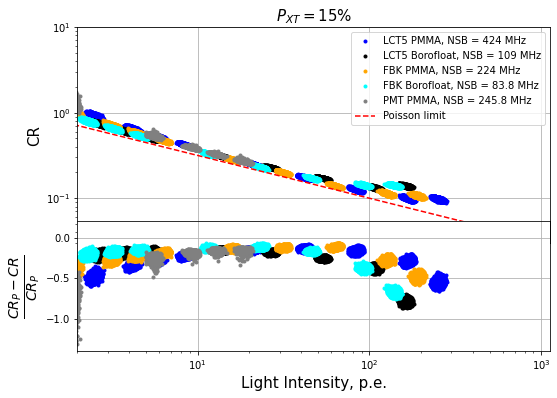

In [35]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.03, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.3],
                   ylim=(-1.4, 0.2), xlim=(2, 1120))


x = np.linspace(0, 1000)

ax1.plot(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
ax1.plot(npe_hkb_15_fl, q_hkb_15_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 109 MHz')

ax1.plot(npe_fbk_pmma_15_fl, q_fbk_pmma_15_fl, '.', color = 'orange', label='FBK PMMA, NSB = 224 MHz')
ax1.plot(npe_fbk_15_fl, q_fbk_15_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 83.8 MHz')
ax1.plot(npe_pmt_pmma_fl, q_pmt_pmma_fl, '.', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
#ax1.plot(ngamma_hkb_pmma_15_fl, 1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)), '.', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')

ax1.set_title(r'$P_{XT} = 15 \%$',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax2.plot(np.cos(x));
ax2.plot(npe_hkb_pmma_15_fl, (1./np.sqrt(np.array(npe_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_15_fl))), '.', color = 'blue', label='LCT5 PMMA, NSB = 424 MHz')
ax2.plot(npe_hkb_15_fl, (1./np.sqrt(np.array(npe_hkb_15_fl)) - np.array(q_hkb_15_fl))/(1./np.sqrt(np.array(npe_hkb_15_fl))), '.', color = 'black', label='LCT5 Borofloat, NSB = 109 MHz')
ax2.plot(npe_fbk_pmma_15_fl, (1./np.sqrt(np.array(npe_fbk_pmma_15_fl)) - np.array(q_fbk_pmma_15_fl))/(1./np.sqrt(np.array(npe_fbk_pmma_15_fl))), '.', color = 'orange', label='FBK PMMA, NSB = 224 MHz')
ax2.plot(npe_fbk_15_fl, (1./np.sqrt(np.array(npe_fbk_15_fl)) - np.array(q_fbk_15_fl))/(1./np.sqrt(np.array(npe_fbk_15_fl))), '.', color = 'cyan', label='FBK Borofloat, NSB = 83.8 MHz')
ax2.plot(npe_pmt_pmma_fl, (1./np.sqrt(np.array(npe_pmt_pmma_fl)) - np.array(q_pmt_pmma_fl))/(1./np.sqrt(np.array(npe_pmt_pmma_fl))), '.', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P} - CR}{CR_{P}}$',  fontsize=20)

#ax2.legend()
ax2.grid()
ax2.set_xlabel('Light Intensity, p.e.',  fontsize=15)
#fig.savefig('charge_resolution_pe_Pxt_15.png')

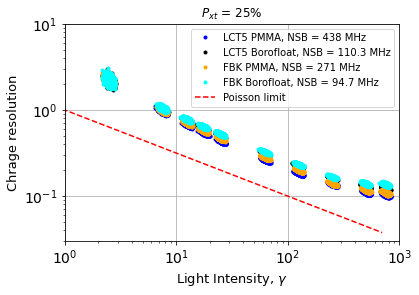

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'blue', label='LCT5 PMMA, NSB = 438 MHz')
plt.plot(ngamma_hkb_25_fl, q_hkb_25_fl, '.', color = 'black', label='LCT5 Borofloat, NSB = 110.3 MHz')

plt.plot(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl, '.', color = 'orange', label='FBK PMMA, NSB = 271 MHz')
plt.plot(ngamma_fbk_25_fl, q_fbk_25_fl, '.', color = 'cyan', label='FBK Borofloat, NSB = 94.7 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('$P_{xt}$ = 25%')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_Pxt_25.png', dpi=800)
plt.show()

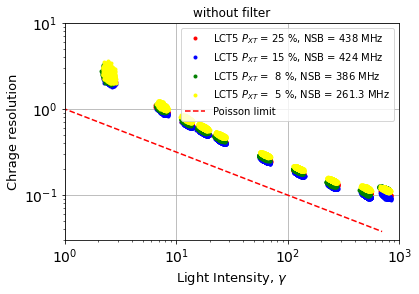

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
plt.plot(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
plt.plot(ngamma_hkb_pmma_5_fl, q_hkb_pmma_5_fl, '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_PMMA.png', dpi=800)
plt.show()

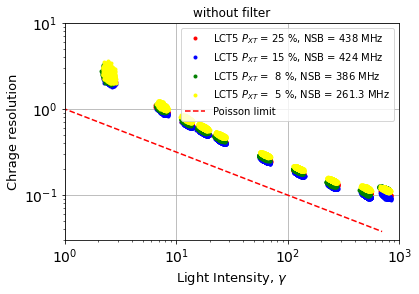

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

degradation = 1.

plt.plot(ngamma_hkb_pmma_25_fl/degradation, q_hkb_pmma_25_fl, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.plot(ngamma_hkb_pmma_15_fl/degradation, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
plt.plot(ngamma_hkb_pmma_8_fl/degradation, q_hkb_pmma_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
plt.plot(ngamma_hkb_pmma_5_fl/degradation, q_hkb_pmma_5_fl, '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_PMMA.png', dpi=800)
plt.show()

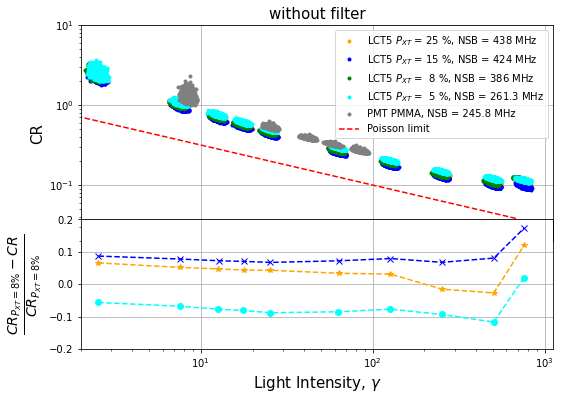

In [37]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.3],
                   ylim=(-0.2, 0.2), xlim=(2, 1120))

degradation = 1
ngamma_hkb_pmma_25_fl = ngamma_hkb_pmma_25_fl/degradation
ngamma_hkb_pmma_15_fl = ngamma_hkb_pmma_15_fl/degradation
ngamma_hkb_pmma_8_fl = ngamma_hkb_pmma_8_fl/degradation
ngamma_hkb_pmma_5_fl = ngamma_hkb_pmma_5_fl/degradation

n_gamma_hkb_pmma_25_mean = np.array(n_gamma_hkb_pmma_25_mean)/degradation
n_gamma_hkb_pmma_15_mean = np.array(n_gamma_hkb_pmma_15_mean)/degradation
n_gamma_hkb_pmma_8_mean = np.array(n_gamma_hkb_pmma_8_mean)/degradation
n_gamma_hkb_pmma_5_mean = np.array(n_gamma_hkb_pmma_5_mean)/degradation

x = np.linspace(0, 1000)

ax1.plot(ngamma_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax1.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax1.plot(ngamma_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
ax1.plot(ngamma_hkb_pmma_5_fl, q_hkb_pmma_5_fl, '.', color = 'cyan',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

ax1.plot(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, '.', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
#ax1.plot(ngamma_hkb_pmma_15_fl, 1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)), '.', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')

ax1.set_title('without filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax2.plot(np.cos(x));
#ax2.plot(ngamma_hkb_pmma_25_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl))), '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
#ax2.plot(ngamma_hkb_pmma_15_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl))), '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
#ax2.plot(ngamma_hkb_pmma_8_fl,  (1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))  - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))), '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
#ax2.plot(ngamma_hkb_pmma_5_fl,  (1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))  - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))), '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

ax2.plot(n_gamma_hkb_pmma_25_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_25_mean))/(np.array(cr_hkb_pmma_8_mean))), '--*', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax2.plot(n_gamma_hkb_pmma_15_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_15_mean))/(np.array(cr_hkb_pmma_8_mean))), '--x', color = 'blue', label='LCT5 $P_{XT}$ =  15 %, ')
ax2.plot(n_gamma_hkb_pmma_5_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_8_mean))), '--o', color = 'cyan', label='LCT5 $P_{XT}$ =  8 %, ')

#ax2.plot(ngamma_pmt_pmma_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_8_mean))), '--o', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P_{XT} = 8 \%} - CR}{CR_{P_{XT} = 8 \%}}$',  fontsize=20)

#ax2.legend()
ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_without_gammas.png')

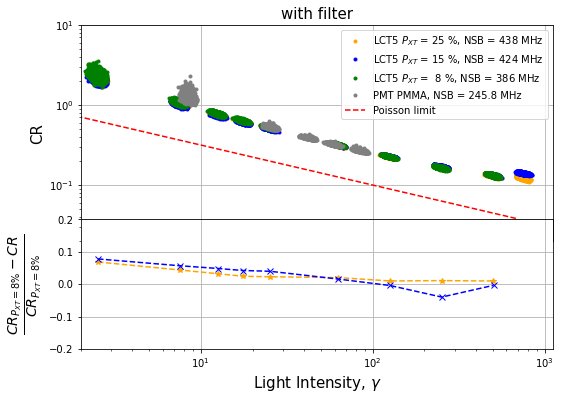

In [45]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.3],
                   ylim=(-0.2, 0.2), xlim=(2, 1120))

degradation = 1
ngamma_hkb_pmma_25_fl = ngamma_hkb_pmma_25_fl/degradation
ngamma_hkb_pmma_15_fl = ngamma_hkb_pmma_15_fl/degradation
ngamma_hkb_pmma_8_fl = ngamma_hkb_pmma_8_fl/degradation
#ngamma_hkb_pmma_5_fl = ngamma_hkb_pmma_5_fl/degradation

n_gamma_hkb_pmma_25_mean = np.array(n_gamma_hkb_pmma_25_mean)/degradation
n_gamma_hkb_pmma_15_mean = np.array(n_gamma_hkb_pmma_15_mean)/degradation
n_gamma_hkb_pmma_8_mean = np.array(n_gamma_hkb_pmma_8_mean)/degradation
#n_gamma_hkb_pmma_5_mean = np.array(n_gamma_hkb_pmma_5_mean)/degradation

x = np.linspace(0, 1000)

ax1.plot(ngamma_hkb_25_fl, q_hkb_25_fl, '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax1.plot(ngamma_hkb_15_fl, q_hkb_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax1.plot(ngamma_hkb_8_fl, q_hkb_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
#ax1.plot(ngamma_hkb_5_fl, q_hkb_5_fl, '.', color = 'cyan',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

ax1.plot(ngamma_pmt_pmma_fl, q_pmt_pmma_fl, '.', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
#ax1.plot(ngamma_hkb_pmma_15_fl, 1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)), '.', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')

ax1.set_title('with filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax2.plot(np.cos(x));
#ax2.plot(ngamma_hkb_pmma_25_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_25_fl))), '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
#ax2.plot(ngamma_hkb_pmma_15_fl, (1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl))), '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
#ax2.plot(ngamma_hkb_pmma_8_fl,  (1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))  - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_8_fl))), '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
#ax2.plot(ngamma_hkb_pmma_5_fl,  (1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))  - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(ngamma_hkb_pmma_5_fl))), '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

ax2.plot(n_gamma_hkb_25_mean[:-1], ((np.array(cr_hkb_8_mean) - np.array(cr_hkb_25_mean[:-1]))/(np.array(cr_hkb_8_mean))), '--*', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax2.plot(n_gamma_hkb_15_mean[:-1], ((np.array(cr_hkb_8_mean) - np.array(cr_hkb_15_mean[:-1]))/(np.array(cr_hkb_8_mean))), '--x', color = 'blue', label='LCT5 $P_{XT}$ =  15 %, ')
#ax2.plot(n_gamma_hkb_5_mean, ((np.array(cr_hkb_8_mean) - np.array(cr_hkb_5_mean))/(np.array(cr_hkb_8_mean))), '--o', color = 'cyan', label='LCT5 $P_{XT}$ =  8 %, ')

#ax2.plot(ngamma_pmt_pmma_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_8_mean))), '--o', color = 'gray', label='PMT PMMA, NSB = 245.8 MHz')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P_{XT} = 8 \%} - CR}{CR_{P_{XT} = 8 \%}}$',  fontsize=20)

#ax2.legend()
ax2.grid()
ax2.set_xlabel('Light Intensity, $\gamma$',  fontsize=15)

fig.savefig('charge_resolution_with_gammas.png')

In [43]:
len(cr_hkb_25_mean)

10

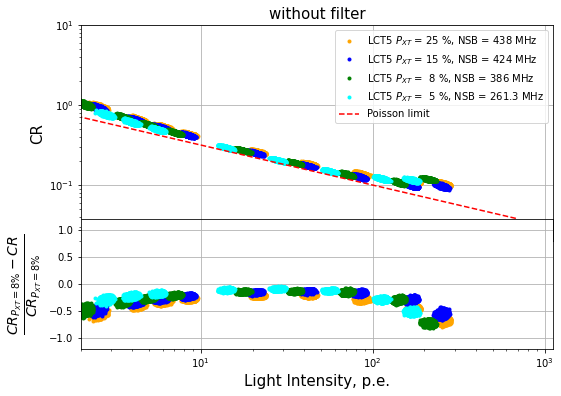

In [68]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.3],
                   ylim=(-1.2, 1.2), xlim=(2, 1120))

#degradation = 1
#ngamma_hkb_pmma_25_fl = ngamma_hkb_pmma_25_fl/degradation
#ngamma_hkb_pmma_15_fl = ngamma_hkb_pmma_15_fl/degradation
#ngamma_hkb_pmma_8_fl = ngamma_hkb_pmma_8_fl/degradation
#ngamma_hkb_pmma_5_fl = ngamma_hkb_pmma_5_fl/degradation

#n_gamma_hkb_pmma_25_mean = np.array(n_gamma_hkb_pmma_25_mean)/degradation
#n_gamma_hkb_pmma_15_mean = np.array(n_gamma_hkb_pmma_15_mean)/degradation
#n_gamma_hkb_pmma_8_mean = np.array(n_gamma_hkb_pmma_8_mean)/degradation
#n_gamma_hkb_pmma_5_mean = np.array(n_gamma_hkb_pmma_5_mean)/degradation

x = np.linspace(0, 1000)

ax1.plot(npe_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax1.plot(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax1.plot(npe_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
ax1.plot(npe_hkb_pmma_5_fl, q_hkb_pmma_5_fl, '.', color = 'cyan',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
#ax1.plot(ngamma_hkb_pmma_15_fl, 1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)), '.', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')

ax1.set_title('without filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax2.plot(np.cos(x));
ax2.plot(npe_hkb_pmma_25_fl, (1./np.sqrt(np.array(npe_hkb_pmma_25_fl)) - np.array(q_hkb_pmma_25_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_25_fl))), '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax2.plot(npe_hkb_pmma_15_fl, (1./np.sqrt(np.array(npe_hkb_pmma_15_fl)) - np.array(q_hkb_pmma_15_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_15_fl))), '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax2.plot(npe_hkb_pmma_8_fl,  (1./np.sqrt(np.array(npe_hkb_pmma_8_fl))  - np.array(q_hkb_pmma_8_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_8_fl))), '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
ax2.plot(npe_hkb_pmma_5_fl,  (1./np.sqrt(np.array(npe_hkb_pmma_5_fl))  - np.array(q_hkb_pmma_5_fl))/(1./np.sqrt(np.array(npe_hkb_pmma_5_fl))), '.', color = 'cyan',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

#ax2.plot(npe_hkb_pmma_25_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_25_mean))/(np.array(cr_hkb_pmma_8_mean))), '--*', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
#ax2.plot(npe_hkb_pmma_15_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_15_mean))/(np.array(cr_hkb_pmma_8_mean))), '--x', color = 'blue', label='LCT5 $P_{XT}$ =  15 %, ')
#ax2.plot(npe_hkb_pmma_5_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_8_mean))), '--o', color = 'cyan', label='LCT5 $P_{XT}$ =  8 %, ')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P_{XT} = 8 \%} - CR}{CR_{P_{XT} = 8 \%}}$',  fontsize=20)

#ax2.legend()
ax2.grid()
ax2.set_xlabel('Light Intensity, p.e.',  fontsize=15)

fig.savefig('charge_resolution_without_pe.png')

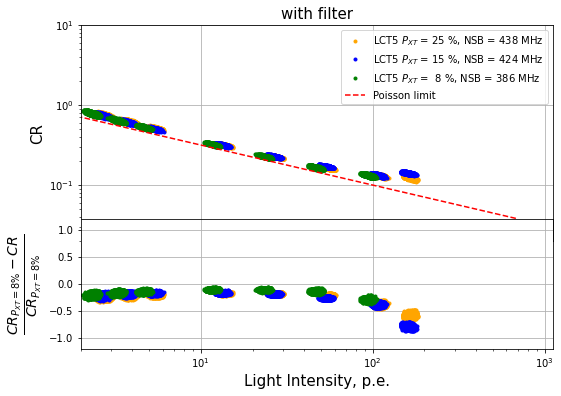

In [70]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_axes([0.15, 0.4, 0.82, 0.5],
                   xticklabels=[], ylim=(0.02, 10), xlim=(2, 1120))


ax2 = fig.add_axes([0.15, 0.15, 0.82, 0.3],
                   ylim=(-1.2, 1.2), xlim=(2, 1120))

#degradation = 1
#ngamma_hkb_pmma_25_fl = ngamma_hkb_pmma_25_fl/degradation
#ngamma_hkb_pmma_15_fl = ngamma_hkb_pmma_15_fl/degradation
#ngamma_hkb_pmma_8_fl = ngamma_hkb_pmma_8_fl/degradation
#ngamma_hkb_pmma_5_fl = ngamma_hkb_pmma_5_fl/degradation

#n_gamma_hkb_pmma_25_mean = np.array(n_gamma_hkb_pmma_25_mean)/degradation
#n_gamma_hkb_pmma_15_mean = np.array(n_gamma_hkb_pmma_15_mean)/degradation
#n_gamma_hkb_pmma_8_mean = np.array(n_gamma_hkb_pmma_8_mean)/degradation
#n_gamma_hkb_pmma_5_mean = np.array(n_gamma_hkb_pmma_5_mean)/degradation

x = np.linspace(0, 1000)

ax1.plot(npe_hkb_25_fl, q_hkb_25_fl, '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax1.plot(npe_hkb_15_fl, q_hkb_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax1.plot(npe_hkb_8_fl, q_hkb_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')

ax1.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
#ax1.plot(ngamma_hkb_pmma_15_fl, 1./np.sqrt(np.array(ngamma_hkb_pmma_15_fl)), '.', color = 'red', label='LCT5 PMMA, NSB = 424 MHz')

ax1.set_title('with filter',  fontsize=15)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid()
ax1.set_ylabel('CR',  fontsize=15)

#ax2.plot(np.cos(x));
ax2.plot(npe_hkb_25_fl, (1./np.sqrt(np.array(npe_hkb_25_fl)) - np.array(q_hkb_25_fl))/(1./np.sqrt(np.array(npe_hkb_25_fl))), '.', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
ax2.plot(npe_hkb_15_fl, (1./np.sqrt(np.array(npe_hkb_15_fl)) - np.array(q_hkb_15_fl))/(1./np.sqrt(np.array(npe_hkb_15_fl))), '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
ax2.plot(npe_hkb_8_fl,  (1./np.sqrt(np.array(npe_hkb_8_fl))  - np.array(q_hkb_8_fl))/(1./np.sqrt(np.array(npe_hkb_8_fl))), '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')

#ax2.plot(npe_hkb_pmma_25_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_25_mean))/(np.array(cr_hkb_pmma_8_mean))), '--*', color = 'orange', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
#ax2.plot(npe_hkb_pmma_15_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_15_mean))/(np.array(cr_hkb_pmma_8_mean))), '--x', color = 'blue', label='LCT5 $P_{XT}$ =  15 %, ')
#ax2.plot(npe_hkb_pmma_5_mean, ((np.array(cr_hkb_pmma_8_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_8_mean))), '--o', color = 'cyan', label='LCT5 $P_{XT}$ =  8 %, ')

ax2.set_xscale('log')
ax2.set_ylabel(r'$\frac{CR_{P_{XT} = 8 \%} - CR}{CR_{P_{XT} = 8 \%}}$',  fontsize=20)

#ax2.legend()
ax2.grid()
ax2.set_xlabel('Light Intensity, p.e.',  fontsize=15)

fig.savefig('charge_resolution_without_pe.png')

In [64]:
npe_hkb_pmma_25_mean

array([  0.86943477,   2.60834691,   4.34486666,   6.08528856,
         8.69383742,  21.72683029,  43.47224167,  86.95199587,
       173.92015782, 260.7658721 ])

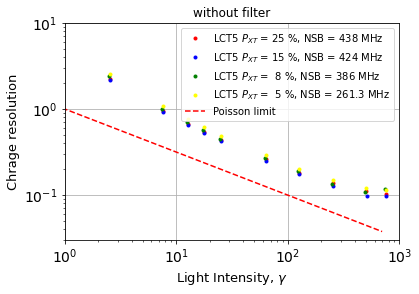

In [254]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(n_gamma_hkb_pmma_25_mean, cr_hkb_pmma_25_mean, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.plot(n_gamma_hkb_pmma_15_mean, cr_hkb_pmma_15_mean, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
plt.plot(n_gamma_hkb_pmma_8_mean, cr_hkb_pmma_8_mean, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
plt.plot(n_gamma_hkb_pmma_5_mean, cr_hkb_pmma_5_mean, '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_gammas_PMMA.png', dpi=800)
plt.show()

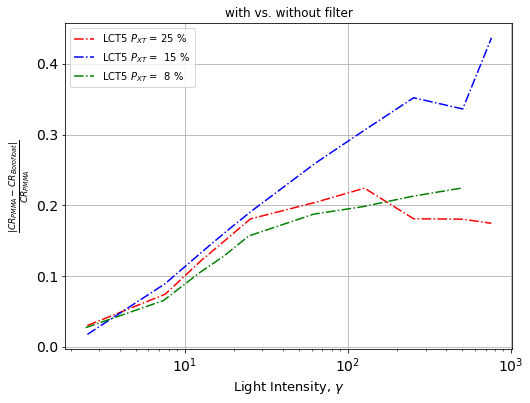

In [345]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(n_gamma_hkb_pmma_25_mean, np.fabs((np.array(cr_hkb_pmma_25_mean) - np.array(cr_hkb_25_mean))/(np.array(cr_hkb_pmma_25_mean))), '-.', color = 'red', label='LCT5 $P_{XT}$ = 25 %')
plt.plot(n_gamma_hkb_pmma_15_mean, np.fabs((np.array(cr_hkb_pmma_15_mean) - np.array(cr_hkb_15_mean))/(np.array(cr_hkb_pmma_15_mean))), '-.', color = 'blue', label='LCT5 $P_{XT}$ =  15 %')
plt.plot(n_gamma_hkb_pmma_8_mean[:-1], np.fabs((np.array(cr_hkb_pmma_8_mean[:-1]) - np.array(cr_hkb_8_mean))/(np.array(cr_hkb_pmma_8_mean[:-1]))), '-.', color = 'green', label='LCT5 $P_{XT}$ =  8 %')
#plt.plot(n_gamma_hkb_pmma_5_mean, np.fabs((np.array(cr_hkb_pmma_5_mean) - np.array(cr_hkb_5_mean))/(np.array(cr_hkb_pmma_5_mean))), '-.', color = 'blue', label='LCT5 $P_{XT}$ =  5 %')

plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
#plt.ylim([0.0, 0.22])
#plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('with vs. without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel(r'$\frac{|CR_{PMMA} - CR_{Borofloat}|}{CR_{PMMA}}$', fontsize=13)
#plt.ylabel('$"(CR_{15} - CR)/CR_{15}$',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_diff_PMMA_Borofloat.png', dpi=800)
plt.show()

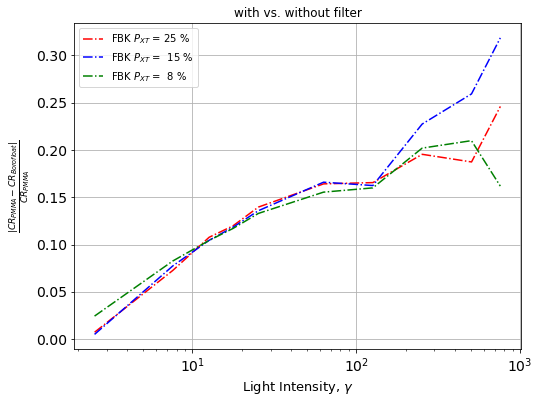

In [352]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(n_gamma_fbk_pmma_25_mean, np.fabs((np.array(cr_fbk_pmma_25_mean) - np.array(cr_fbk_25_mean))/(np.array(cr_fbk_pmma_25_mean))), '-.', color = 'red', label='FBK $P_{XT}$ = 25 %')
plt.plot(n_gamma_fbk_pmma_15_mean, np.fabs((np.array(cr_fbk_pmma_15_mean) - np.array(cr_fbk_15_mean))/(np.array(cr_fbk_pmma_15_mean))), '-.', color = 'blue', label='FBK $P_{XT}$ =  15 %')
plt.plot(n_gamma_fbk_pmma_8_mean, np.fabs((np.array(cr_fbk_pmma_8_mean) - np.array(cr_fbk_8_mean))/(np.array(cr_fbk_pmma_8_mean))), '-.', color = 'green', label='FBK $P_{XT}$ =  8 %')
#plt.plot(n_gamma_hkb_pmma_5_mean, np.fabs((np.array(cr_hkb_pmma_5_mean) - np.array(cr_hkb_5_mean))/(np.array(cr_hkb_pmma_5_mean))), '-.', color = 'blue', label='LCT5 $P_{XT}$ =  5 %')

plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
#plt.ylim([0.0, 0.22])
#plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('with vs. without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel(r'$\frac{|CR_{PMMA} - CR_{Borofloat}|}{CR_{PMMA}}$', fontsize=13)
#plt.ylabel('$"(CR_{15} - CR)/CR_{15}$',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_diff_PMMA_Borofloat.png', dpi=800)
plt.show()

In [350]:
len(cr_fbk_8_mean)

10

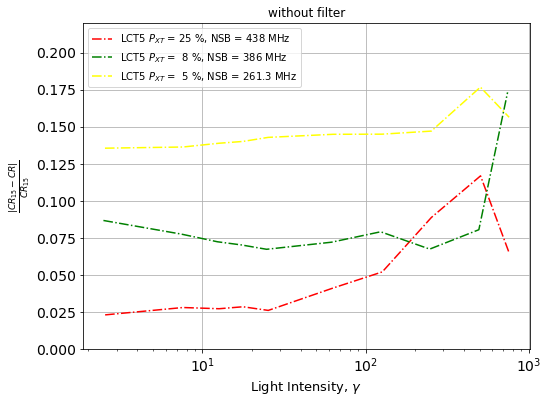

In [327]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(n_gamma_hkb_pmma_25_mean, np.fabs((np.array(cr_hkb_pmma_15_mean) - np.array(cr_hkb_pmma_25_mean))/(np.array(cr_hkb_pmma_15_mean))), '-.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.plot(n_gamma_hkb_pmma_8_mean, np.fabs((np.array(cr_hkb_pmma_15_mean) - np.array(cr_hkb_pmma_8_mean))/(np.array(cr_hkb_pmma_8_mean))), '-.', color = 'green', label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
plt.plot(n_gamma_hkb_pmma_5_mean, np.fabs((np.array(cr_hkb_pmma_15_mean) - np.array(cr_hkb_pmma_5_mean))/(np.array(cr_hkb_pmma_5_mean))), '-.', color = 'yellow', label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')
#plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
plt.ylim([0.0, 0.22])
#plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel(r'$\frac{|CR_{15} - CR|}{CR_{15}}$', fontsize=13)
#plt.ylabel('$"(CR_{15} - CR)/CR_{15}$',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_diff_gammas_PMMA.png', dpi=800)
plt.show()

In [256]:
np.array(cr_hkb_pmma_15_mean) - np.array(cr_hkb_pmma_25_mean)

array([-0.05068963, -0.02605727, -0.01780297, -0.01501025, -0.01101396,
       -0.01032871, -0.00907358, -0.01123803, -0.01157335, -0.00630949])

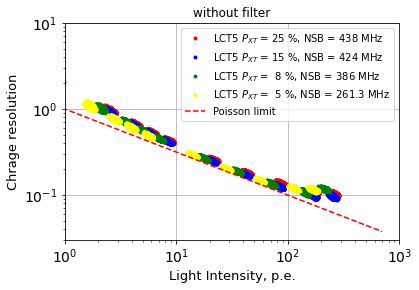

In [249]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(npe_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.plot(npe_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5 $P_{XT}$ = 15 %, NSB = 424 MHz')
plt.plot(npe_hkb_pmma_8_fl, q_hkb_pmma_8_fl, '.', color = 'green',  label='LCT5 $P_{XT}$ =  8 %, NSB = 386 MHz')
plt.plot(npe_hkb_pmma_5_fl, q_hkb_pmma_5_fl, '.', color = 'yellow',  label='LCT5 $P_{XT}$ =  5 %, NSB = 261.3 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, p.e.',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
plt.savefig('charge_resolution_pe_PMMA.png', dpi=800)
plt.show()

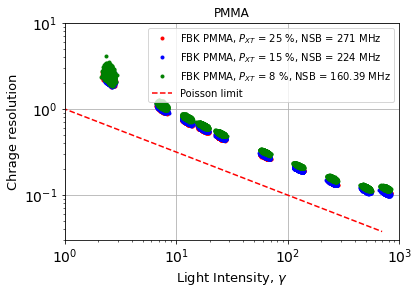

In [244]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_fbk_pmma_25_fl, q_fbk_pmma_25_fl, '.', color = 'red', label='FBK PMMA, $P_{XT}$ = 25 %, NSB = 271 MHz')
plt.plot(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl, '.', color = 'blue', label='FBK PMMA, $P_{XT}$ = 15 %, NSB = 224 MHz')
plt.plot(ngamma_fbk_pmma_8_fl, q_fbk_pmma_8_fl, '.', color = 'green',  label='FBK PMMA, $P_{XT}$ = 8 %, NSB = 160.39 MHz')

plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('without filter')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_Pxt_8.png', dpi=800)
plt.show()

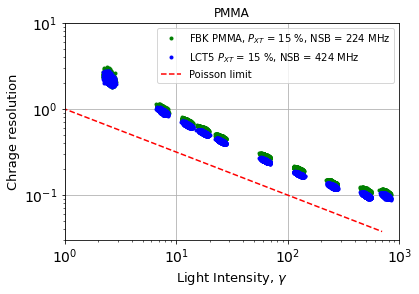

In [246]:
fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(ngamma_fbk_pmma_15_fl, q_fbk_pmma_15_fl, '.', color = 'green', label='FBK, $P_{XT}$ = 15 %, NSB = 224 MHz')
plt.plot(ngamma_hkb_pmma_15_fl, q_hkb_pmma_15_fl, '.', color = 'blue', label='LCT5, $P_{XT}$ = 15 %, NSB = 424 MHz')
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.ylim([0.03, 10])
plt.xlim([1, 1000])
plt.legend(fontsize=10)
plt.title('PMMA')
plt.xlabel('Light Intensity, $\gamma$',  fontsize=13)
plt.xticks(fontsize=14)
plt.ylabel('Chrage resolution',  fontsize=13)
plt.yticks(fontsize=14)
#plt.savefig('charge_resolution_gammas_Pxt_8.png', dpi=800)
plt.show()

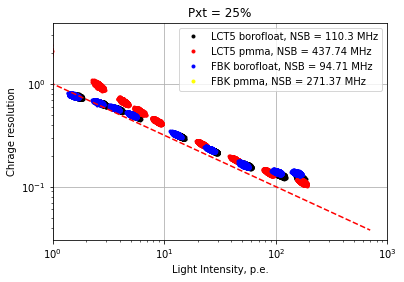

In [155]:
plt.plot(npe_hkb_25_fl, q_hkb_25_fl, '.', color = 'black', label='LCT5 borofloat, NSB = 110.3 MHz')
plt.plot(npe_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'red', label='LCT5 pmma, NSB = 437.74 MHz')

plt.plot(npe_fbk_25_fl, q_fbk_25_fl, '.', color = 'blue', label='FBK borofloat, NSB = 94.71 MHz')
plt.plot(npe_fbk_pmma_25_fl, q_fbk_pmma_25_fl, '.', color = 'yellow', label='FBK pmma, NSB = 271.37 MHz')

plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.title('Pxt = 25%')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Chrage resolution')
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit, gammas')
plt.xlim([1., 1000])
#plt.savefig('charge_resolution_all_nsb_pe.png')
plt.show()

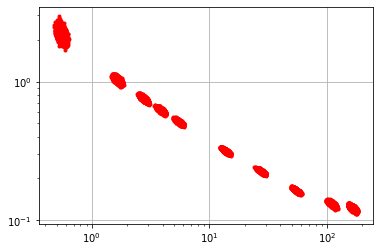

In [213]:
plt.plot(npe_hkb_25_fl, q_hkb_25_fl, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 110 MHz')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

In [214]:
npe_hkb_25_fl

array([0.5735 , 0.56675, 0.56575, ..., 2.66475, 2.64225, 2.60825])

In [299]:
index = [ 0.48690579,   1.31267346,
         4.43764774,   7.73658464,  35.55768132, 
       215.16943103]
index2 = [ 81.85369789,  62.33391299,  83.87626621, 105.54040485,
       144.93372151, 260.13924719, 320.974496  , 398.94449841]

cr2 = [0.22007330092127098,
 0.3613892593367857,
 0.2583507852973539,
 0.24093334593931554,
 0.2058419968134779,
 0.14144234713890658,
 0.12387324881925385,
 0.008789543306712127]
cr = [
 2.8240181508515194,
 1.3538032174300183,
 0.6204412363018104,
 0.4613731550839298,
 0.2629024155571519,
 0.11370478958412274]

In [280]:
index

[0.39659611,
 0.48756463,
 0.48690579,
 1.31267346,
 4.43764774,
 7.73658464,
 35.55768132,
 80.79911173,
 215.16943103,
 359.69806629,
 0.58651062]

In [290]:
my_sort(index, cr, index, cr)

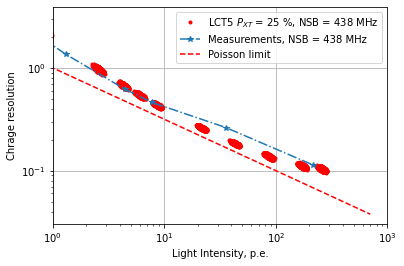

In [329]:
plt.plot(npe_hkb_pmma_25_fl, q_hkb_pmma_25_fl, '.', color = 'red', label='LCT5 $P_{XT}$ = 25 %, NSB = 438 MHz')
plt.xscale('log')
plt.yscale('log')
plt.plot(index, cr, '-.*', label='Measurements, NSB = 438 MHz')
plt.xlabel('Light Intensity, p.e.')
plt.ylabel('Chrage resolution')
plt.grid(True)
plt.xlim([1, 1000])
plt.plot(gammas_poisson, charge_resolution_poisson_gammas, '--r', label='Poisson limit')
plt.legend()
plt.savefig('data_comparison.png')